In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [30]:
import pandas as pd
import numpy as np
from collections import Counter
import warnings
import logging

import spacy
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore, LdaModel
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim

from tqdm._tqdm_notebook import tqdm, tqdm_notebook, tnrange
from S3_read_write import load_df_s3, save_df_s3

from IPython.display import Image
from IPython.core.display import HTML

In [3]:
tqdm_notebook.pandas('Progress')

In [4]:
bucket_name = 'amazon-reviews-project'

In [32]:
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.DEBUG)

# Load Amazon Reviews Data

Let us start off using only the title (`summary`) and body (`reviewText`) of each review.

In [5]:
%%time
df = load_df_s3(bucket_name, filepath='amazon_reviews/data_clean_v3', filetype='feather')

# df = load_df_s3(bucket_name, filepath='amazon_reviews/reviews_data_clean_v2.feather', filetype='feather')

CPU times: user 2.11 s, sys: 1.94 s, total: 4.05 s
Wall time: 10.7 s


In [6]:
df.dtypes

index                 int64
asin                 object
helpful              object
reviewText           object
overall             float64
summary              object
description          object
title                object
categories_clean     object
cat1                 object
cat2                 object
cat3                 object
cat4                 object
cat5                 object
cat6                 object
cat7                 object
dtype: object

In [7]:
df = df.loc[:, ['asin', 'reviewText', 'summary']]

In [8]:
df.shape

(217530, 3)

In [9]:
df.head()

,asin,reviewText,summary
0,0978559088,I started taking this after both my parents di...,Bioavailability is the key
1,0978559088,I really liked this product because it stayed ...,"I can't find this product any longer, and I wi..."
2,0978559088,"Resveratrol is a polar compound, very insolubl...",Just the Resveratrol product we need
3,1427600228,I bought several of these bracelets for my YMC...,The kids love these bracelets
4,1427600228,I bought a few the other week just to see what...,Pleasant Surprise


In [10]:
# for each review, concatenate the review title and body
df.reviewText = df.summary + '. ' + df.reviewText

In [11]:
pd.set_option('max_colwidth', 200)
df.head()

,asin,reviewText,summary
0,0978559088,Bioavailability is the key. I started taking this after both my parents died of cancer as it supposed to enhance your immune system - the story on 60 Minutes on resveratrol was incredibly inspirin...,Bioavailability is the key
1,0978559088,"I can't find this product any longer, and I wish I could.. I really liked this product because it stayed in my mouth for a long time and I felt it was probably doing some good. I take a number of...","I can't find this product any longer, and I wish I could."
2,0978559088,"Just the Resveratrol product we need. Resveratrol is a polar compound, very insoluble in water and hence saliva. To get sufficient Resveratrol absorbed a Resveratrol lozenge would have to stay in...",Just the Resveratrol product we need
3,1427600228,"The kids love these bracelets. I bought several of these bracelets for my YMCA kids. Everyone tells me that it brought good luck. Placebo effect, perhaps but it's a positive effect and builds conf...",The kids love these bracelets
4,1427600228,Pleasant Surprise. I bought a few the other week just to see what they're all about. The first day I wore one of the bracelets three people asked about it. They liked the look. I told them it w...,Pleasant Surprise


Let's drop the `summary` column now:

In [12]:
df.drop(['summary'], axis=1, inplace=True)

In [13]:
df.head()

,asin,reviewText
0,0978559088,Bioavailability is the key. I started taking this after both my parents died of cancer as it supposed to enhance your immune system - the story on 60 Minutes on resveratrol was incredibly inspirin...
1,0978559088,"I can't find this product any longer, and I wish I could.. I really liked this product because it stayed in my mouth for a long time and I felt it was probably doing some good. I take a number of..."
2,0978559088,"Just the Resveratrol product we need. Resveratrol is a polar compound, very insoluble in water and hence saliva. To get sufficient Resveratrol absorbed a Resveratrol lozenge would have to stay in..."
3,1427600228,"The kids love these bracelets. I bought several of these bracelets for my YMCA kids. Everyone tells me that it brought good luck. Placebo effect, perhaps but it's a positive effect and builds conf..."
4,1427600228,Pleasant Surprise. I bought a few the other week just to see what they're all about. The first day I wore one of the bracelets three people asked about it. They liked the look. I told them it w...


In [14]:
pd.set_option('max_colwidth', 20)

## Remove Missing Reviews

In [15]:
df.reviewText.isnull().sum()    # 73 reviews have neither a review body text, nor a review title

0

Let's look at a few actual review texts:

In [16]:
df.reviewText.iloc[np.random.randint(0, len(df))]

'Great product. A friend told me about this and I love it. It works just like it says. Highly recommend this product.'

In [17]:
df.reviewText.iloc[np.random.randint(0, len(df))]

'Yes! It works fast and lowers your BP withi a month.. It works...it works...lowered my blood pressure by 30 points. I take 2 pills in the AM and 2 in the afternoon. My BP was high and now it is borderline.'

In [18]:
df.reviewText.iloc[np.random.randint(0, len(df))]

"I love it!. I am very sensitive to most things. I can't drink coffee, I can't drink soda, I can't drink most green teas. However with this, I can have just one teaspoon of the Matcha Green Tea with water and I feel a gradual alertness that stays for quite some time with no crashing. I also find it curbs my appetite. Love it!"

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217530 entries, 0 to 217529
Data columns (total 2 columns):
asin          217530 non-null object
reviewText    217530 non-null object
dtypes: object(2)
memory usage: 3.3+ MB


## Phrase Detection

In [20]:
text = list(df.reviewText.values)    # make an iterable to store only the review text

In [21]:
[sent for sent in text if len(sent) == 0]   # there are no blank sentences

[]

In [22]:
len(text)

217530

In [23]:
# look at a few sample reviews
for rev in text[:4]:
    print(rev, '\n')

Bioavailability is the key. I started taking this after both my parents died of cancer as it supposed to enhance your immune system - the story on 60 Minutes on resveratrol was incredibly inspiring. Doing some research on the Internet, it is indicated that taking resveratrol in lozenge form is preferable as it is broken down by stomach acids.  The ez-melt formula recommended in another review is OK, but it is dissolved in the mouth much more quickly than this lozenge formula, while dissolving more slowly is preferable according to my research.This product has the greatest side effect - since taking it, I haven't had colds or sore throats.  Soon after starting to take it every day, I was starting to come down with a cold, with all my usual symptoms, and was anticipating being very sick the next day, as is my usual pattern.  But I never did get as sick as anticipated - taking this product is the only reason I can come up with.  Since then, I've had no colds or sore throats - it has been 

In [24]:
nlp = spacy.load('en')

The helper functions below are from:

http://nbviewer.jupyter.org/github/skipgram/modern-nlp-in-python/blob/master/executable/Modern_NLP_in_Python.ipynb

In order to use `gensim`'s `Phrases` class to detect natural combinations of words (like 'vanilla ice cream'), we need to format our text into a list of sentences, with each sentence being a list of words.  This process takes a large amount of processing time (for reference, the times shown under the cells are for running the tasks on a c5.18xlarge EC2 instance (equivalent spot fleet)), so `text` has been split into 3 parts.

### Generate Unigram Sentences

In [25]:
len(text)

217530

In [26]:
# split text into 9 parts
text_first  = text[:50000]
text_second = text[50000:100000]
text_third  = text[100000:150000]
text_fourth = text[150000:]

In [27]:
rev_num = 0    # review tracker
sent_num = 0   # sentence tracker
unigram_sents_pos = [] # to store lists of lemmatized tokens for each sentence

for parsed_review in tqdm(nlp.pipe(text_first, batch_size=10000, n_threads=72)):
    rev_num += 1
    for sent in parsed_review.sents:
        sent_num += 1
        # lemmatize tokens & save corresponding pos tag after filtering whitespace and punctuations
        lemmatized_sent = [(token.lemma_, token.pos_) for token in sent if not (token.is_space or token.is_punct)]
        if len(lemmatized_sent) != 0:
            unigram_sents_pos.append([rev_num, sent_num, lemmatized_sent])

print('current rev_num: ', rev_num)
print('current sent_num: ', sent_num)

50000it [06:56, 120.02it/s]

current rev_num:  50000
current sent_num:  289565


In [28]:
len(unigram_sents_pos)

289158

In [29]:
for i in range(5):
    print(unigram_sents_pos[i])

[1, 1, [('bioavailability', 'PROPN'), ('be', 'VERB'), ('the', 'DET'), ('key', 'NOUN')]]
[1, 2, [('-PRON-', 'PRON'), ('start', 'VERB'), ('take', 'VERB'), ('this', 'DET'), ('after', 'ADP'), ('both', 'CCONJ'), ('-PRON-', 'ADJ'), ('parent', 'NOUN'), ('die', 'VERB'), ('of', 'ADP'), ('cancer', 'NOUN'), ('as', 'ADP'), ('-PRON-', 'PRON'), ('suppose', 'VERB'), ('to', 'PART'), ('enhance', 'VERB'), ('-PRON-', 'ADJ'), ('immune', 'ADJ'), ('system', 'NOUN'), ('the', 'DET'), ('story', 'NOUN'), ('on', 'ADP'), ('60', 'NUM'), ('minutes', 'PROPN'), ('on', 'ADP'), ('resveratrol', 'NOUN'), ('be', 'VERB'), ('incredibly', 'ADV'), ('inspiring', 'ADJ')]]
[1, 3, [('do', 'VERB'), ('some', 'DET'), ('research', 'NOUN'), ('on', 'ADP'), ('the', 'DET'), ('internet', 'NOUN'), ('-PRON-', 'PRON'), ('be', 'VERB'), ('indicate', 'VERB'), ('that', 'ADP'), ('take', 'VERB'), ('resveratrol', 'NOUN'), ('in', 'ADP'), ('lozenge', 'NOUN'), ('form', 'NOUN'), ('be', 'VERB'), ('preferable', 'ADJ'), ('as', 'ADP'), ('-PRON-', 'PRON'), 

In [30]:
# check if there are any blank sentences
for sent in unigram_sents_pos:
    if len(sent[2]) == 0:
        print(sent)

In [31]:
# Save progress...
review_number = [row[0] for row in unigram_sents_pos]
sentence_number = [row[1] for row in unigram_sents_pos]
words_joined_all = []
pos_joined_all = []
for sent in unigram_sents_pos:
    word_pos = sent[2]
    word_list = [word for word, pos in word_pos]
    pos_list = [pos for word, pos in word_pos]
    words_joined = '+-+||+-+'.join(word for word in word_list)
    pos_joined   = '+-+||+-+'.join(pos for pos in pos_list)
    words_joined_all.append(words_joined)
    pos_joined_all.append(pos_joined)
    
unigram_sentences_savedf = pd.DataFrame({'review_number': review_number,
                                         'sentence_number': sentence_number,
                                         'unigram_sentences': words_joined_all,
                                         'unigram_pos': pos_joined_all})

save_df_s3(unigram_sentences_savedf, bucket_name, 'amazon_reviews/kk/unigram_sentences.feather')

In [32]:
for parsed_review in tqdm(nlp.pipe(text_second, batch_size=20000, n_threads=36)):
    rev_num += 1
    for sent in parsed_review.sents:
        sent_num += 1
        # lemmatize tokens & save corresponding pos tag after filtering whitespace and punctuations
        lemmatized_sent = [(token.lemma_, token.pos_) for token in sent if not (token.is_space or token.is_punct)]
        if len(lemmatized_sent) != 0:
            unigram_sents_pos.append([rev_num, sent_num, lemmatized_sent])

print('current rev_num: ', rev_num)
print('current sent_num: ', sent_num)

50000it [06:55, 120.43it/s]

current rev_num:  100000
current sent_num:  576892


In [33]:
print(len(unigram_sents_pos))

576034


In [34]:
# Save progress...
review_number = [row[0] for row in unigram_sents_pos]
sentence_number = [row[1] for row in unigram_sents_pos]
words_joined_all = []
pos_joined_all = []
for sent in unigram_sents_pos:
    word_pos = sent[2]
    word_list = [word for word, pos in word_pos]
    pos_list = [pos for word, pos in word_pos]
    words_joined = '+-+||+-+'.join(word for word in word_list)
    pos_joined   = '+-+||+-+'.join(pos for pos in pos_list)
    words_joined_all.append(words_joined)
    pos_joined_all.append(pos_joined)
    
unigram_sentences_savedf = pd.DataFrame({'review_number': review_number,
                                         'sentence_number': sentence_number,
                                         'unigram_sentences': words_joined_all,
                                         'unigram_pos': pos_joined_all})

save_df_s3(unigram_sentences_savedf, bucket_name, 'amazon_reviews/kk/unigram_sentences.feather')

In [35]:
for parsed_review in tqdm(nlp.pipe(text_third, batch_size=20000, n_threads=36)):
    rev_num += 1
    for sent in parsed_review.sents:
        sent_num += 1
        # lemmatize tokens & save corresponding pos tag after filtering whitespace and punctuations
        lemmatized_sent = [(token.lemma_, token.pos_) for token in sent if not (token.is_space or token.is_punct)]
        if len(lemmatized_sent) != 0:
            unigram_sents_pos.append([rev_num, sent_num, lemmatized_sent])

print('current rev_num: ', rev_num)
print('current sent_num: ', sent_num)

50000it [06:27, 129.16it/s]

current rev_num:  150000
current sent_num:  855567


In [36]:
# Save progress...
review_number = [row[0] for row in unigram_sents_pos]
sentence_number = [row[1] for row in unigram_sents_pos]
words_joined_all = []
pos_joined_all = []
for sent in unigram_sents_pos:
    word_pos = sent[2]
    word_list = [word for word, pos in word_pos]
    pos_list = [pos for word, pos in word_pos]
    words_joined = '+-+||+-+'.join(word for word in word_list)
    pos_joined   = '+-+||+-+'.join(pos for pos in pos_list)
    words_joined_all.append(words_joined)
    pos_joined_all.append(pos_joined)
    
unigram_sentences_savedf = pd.DataFrame({'review_number': review_number,
                                         'sentence_number': sentence_number,
                                         'unigram_sentences': words_joined_all,
                                         'unigram_pos': pos_joined_all})

save_df_s3(unigram_sentences_savedf, bucket_name, 'amazon_reviews/kk/unigram_sentences.feather')

In [37]:
for parsed_review in tqdm(nlp.pipe(text_fourth, batch_size=20000, n_threads=36)):
    rev_num += 1
    for sent in parsed_review.sents:
        sent_num += 1
        # lemmatize tokens & save corresponding pos tag after filtering whitespace and punctuations
        lemmatized_sent = [(token.lemma_, token.pos_) for token in sent if not (token.is_space or token.is_punct)]
        if len(lemmatized_sent) != 0:
            unigram_sents_pos.append([rev_num, sent_num, lemmatized_sent])

print('current rev_num: ', rev_num)
print('current sent_num: ', sent_num)

67530it [09:13, 122.02it/s]

current rev_num:  217530
current sent_num:  1243596


In [38]:
# Save progress...
review_number = [row[0] for row in unigram_sents_pos]
sentence_number = [row[1] for row in unigram_sents_pos]
words_joined_all = []
pos_joined_all = []
for sent in unigram_sents_pos:
    word_pos = sent[2]
    word_list = [word for word, pos in word_pos]
    pos_list = [pos for word, pos in word_pos]
    words_joined = '+-+||+-+'.join(word for word in word_list)
    pos_joined   = '+-+||+-+'.join(pos for pos in pos_list)
    words_joined_all.append(words_joined)
    pos_joined_all.append(pos_joined)
    
unigram_sentences_savedf = pd.DataFrame({'review_number': review_number,
                                         'sentence_number': sentence_number,
                                         'unigram_sentences': words_joined_all,
                                         'unigram_pos': pos_joined_all})

save_df_s3(unigram_sentences_savedf, bucket_name, 'amazon_reviews/kk/unigram_sentences.feather')

In [39]:
# DON'T LOAD THIS FILE - there's a _v1 version further down!
# del unigram_sentences_savedf
unigram_sentences_savedf = load_df_s3(bucket_name, 'amazon_reviews/kk/unigram_sentences.feather', filetype='feather')

In [40]:
unigram_sentences_savedf.head()

,review_number,sentence_number,unigram_pos,unigram_sentences
0,1,1,PROPN+-+||+-+VER...,bioavailability+...
1,1,2,PRON+-+||+-+VERB...,-PRON-+-+||+-+st...
2,1,3,VERB+-+||+-+DET+...,do+-+||+-+some+-...
3,1,4,DET+-+||+-+ADP+-...,the+-+||+-+ez+-+...
4,1,5,DET+-+||+-+NOUN+...,this+-+||+-+prod...


In [41]:
unigram_sentences_savedf[unigram_sentences_savedf.unigram_pos == ''].shape

(0, 4)

In [42]:
unigram_sentences_savedf[unigram_sentences_savedf.unigram_sentences == ''].shape

(0, 4)

In [43]:
unigram_sentences_savedf[unigram_sentences_savedf.unigram_pos == ''].head()  # no blank sentences

,review_number,sentence_number,unigram_pos,unigram_sentences


In [44]:
unigram_sentences_savedf[unigram_sentences_savedf.unigram_pos == ''].shape

(0, 4)

#### Additional Data Cleaning

In [45]:
def clean_up(sentence, sentence_pos, sep):
    """Expects a sentence as a single string as input 1, and its corresponding part-of-speech tags as input 2 (also single string).
    sep is the string pattern used to separate words in each sentence string
    Cleans it up and returns a single string.
    Also updates corresponding part-of-speech string.
    """
    # get rid of webpage links
    cond = ['http' in sentence, 'www' in sentence]
    if any(cond):
        words = sentence.split(sep)
        words_pos = sentence_pos.split(sep)
        to_remove = []
        for i in range(len(words)):
            cond_word = ['http' in words[i], 'www' in words[i]]
            if any(cond_word):
                to_remove.append(i)
        # remove words that are links
        for j in sorted(to_remove, reverse=True):
            del words[j]
            del words_pos[j]
        # reconstruct sentence after deleting links
        sentence = sep.join(words)
        sentence_pos = sep.join(words_pos)

    # replace underscores with blanks to avoid mix-up with paired words later
    # cannot replace with spaces because the strings are split on spaces later 
    # and this would create new words with no corresponding pos tags
    if '_' in sentence:
        sentence = sentence.replace('_', '')
    return sentence, sentence_pos

In [46]:
test_clean = ['whoa watch out for them links boy http://sup.com and also BAM! underscore_time!', 'this is a normal sentence', 
              '__ what is this ____ http', '_', 'http']
test_clean

['whoa watch out for them links boy http://sup.com and also BAM! underscore_time!',
 'this is a normal sentence',
 '__ what is this ____ http',
 '_',
 'http']

In [47]:
test_clean_pos = ['X X X X X X X X X X X X', 'X X X X X', 'X X X X X X', 'X', 'X']

In [48]:
[len(e.split(' ')) for e in test_clean]

[12, 5, 6, 1, 1]

In [49]:
[e.count('X') for e in test_clean_pos]

[12, 5, 6, 1, 1]

In [50]:
# check if clean_up works as expected
to_remove = []
for i in range(len(test_clean)):
    sentence = test_clean[i]
    sentence_pos = test_clean_pos[i]
    test_clean[i], test_clean_pos[i] = clean_up(sentence, sentence_pos, sep=' ')
    
    # mark elements to delete if empty
    if test_clean[i] == '':
        to_remove.append(i)

# delete elements that are empty
for j in sorted(to_remove, reverse=True):
    del test_clean[j]
    del test_clean_pos[j]

test_clean

['whoa watch out for them links boy and also BAM! underscoretime!',
 'this is a normal sentence',
 ' what is this ']

In [51]:
test_clean_pos

['X X X X X X X X X X X', 'X X X X X', 'X X X X X']

In [52]:
[e.count('X') for e in test_clean_pos]

[11, 5, 5]

In [53]:
[len(e.split(' ')) for e in test_clean]

[11, 5, 5]

In [54]:
words_joined_all = unigram_sentences_savedf.unigram_sentences.tolist()

In [55]:
pos_joined_all = unigram_sentences_savedf.unigram_pos.tolist()

In [56]:
len(words_joined_all)

1241850

In [57]:
len([sentence for sentence in words_joined_all if '_' in sentence])

172

In [58]:
len([sentence for sentence in words_joined_all if 'http' in sentence])

126

In [59]:
len([sentence for sentence in words_joined_all if 'www' in sentence])

157

In [60]:
unigram_sentences_savedf[unigram_sentences_savedf.unigram_sentences.str.contains('_')].head()

,review_number,sentence_number,unigram_pos,unigram_sentences
3375,607,3386,X,http://www.amazo...
8051,1454,8071,DET+-+||+-+NOUN+...,no+-+||+-+jet_la...
12199,2166,12224,ADJ+-+||+-+PART+...,easy+-+||+-+to+-...
12201,2166,12226,PRON+-+||+-+VERB...,-PRON-+-+||+-+ha...
18188,3106,18214,ADV+-+||+-+ADJ+-...,overall+-+||+-+-...


In [61]:
[sentence for sentence in words_joined_all if '_' in sentence][:10]

['http://www.amazon.com/gp/product/b0000533z8/ref=cm_cr_rev_prod_title',
 'no+-+||+-+jet_lag+-+||+-+pill',
 'easy+-+||+-+to+-+||+-+use_work+-+||+-+well',
 '-PRON-+-+||+-+have+-+||+-+have+-+||+-+pedometer+-+||+-+in+-+||+-+the+-+||+-+past_all+-+||+-+difficult+-+||+-+and+-+||+-+confusing+-+||+-+to+-+||+-+use+-+||+-+to+-+||+-+the+-+||+-+point+-+||+-+-PRON-+-+||+-+simply+-+||+-+give+-+||+-+up+-+||+-+on+-+||+-+-PRON-',
 'overall+-+||+-+-PRON-+-+||+-+mother+-+||+-+be+-+||+-+very+-+||+-+satisfied+-+||+-+with+-+||+-+this+-+||+-+product!-d_lionz',
 'this+-+||+-+inexpensive+-+||+-+strap+-+||+-+with+-+||+-+a+-+||+-+metal+-+||+-+clip+-+||+-+http://www.amazon.com/gp/product/b000bitymg/ref=oh_details_o00_s00_i00?ie=utf8&psc;=1+-+||+-+be+-+||+-+a+-+||+-+good+-+||+-+replacement+-+||+-+for+-+||+-+the+-+||+-+flimsy+-+||+-+omron+-+||+-+plastic+-+||+-+clip+-+||+-+but+-+||+-+-PRON-+-+||+-+have+-+||+-+not+-+||+-+be+-+||+-+use+-+||+-+-PRON-+-+||+-+long',
 'hj_112+-+||+-+digital+-+||+-+pemium+-+||+-+pedometer+

In [62]:
# clean up all unigrams
to_remove = []
for i in range(len(words_joined_all)):
    sentence = words_joined_all[i]
    sentence_pos = pos_joined_all[i]
    words_joined_all[i], pos_joined_all[i] = clean_up(sentence, sentence_pos, sep='+-+||+-+')
    
    # mark elements to delete if empty
    if words_joined_all[i] == '':
        to_remove.append(i)

# delete elements that are empty
for j in sorted(to_remove, reverse=True):
    del words_joined_all[j]
    del pos_joined_all[j]

In [63]:
# drop rows from unigram_sentences_savedf corresponding to the row numbers (indices) of sentences
# that will be blank after the transformation above
unigram_sentences_savedf.drop(unigram_sentences_savedf.index[to_remove], axis=0, inplace=True)

In [64]:
unigram_sentences_savedf.drop(['unigram_sentences'], axis=1, inplace=True)
unigram_sentences_savedf.drop(['unigram_pos'], axis=1, inplace=True)

In [65]:
unigram_sentences_savedf['unigram_sentences'] = words_joined_all
unigram_sentences_savedf['unigram_pos'] = pos_joined_all

In [66]:
unigram_sentences_savedf.head()

,review_number,sentence_number,unigram_sentences,unigram_pos
0,1,1,bioavailability+...,PROPN+-+||+-+VER...
1,1,2,-PRON-+-+||+-+st...,PRON+-+||+-+VERB...
2,1,3,do+-+||+-+some+-...,VERB+-+||+-+DET+...
3,1,4,the+-+||+-+ez+-+...,DET+-+||+-+ADP+-...
4,1,5,this+-+||+-+prod...,DET+-+||+-+NOUN+...


In [68]:
unigram_sentences_savedf.shape

(1241826, 4)

In [69]:
# updated, cleaned up version of unigram_sentences.feather
save_df_s3(unigram_sentences_savedf, bucket_name, 'amazon_reviews/kk/unigram_sentences_v1.feather')

### Phrase Detection

In [21]:
unigram_sentences_savedf = load_df_s3(bucket_name, 'amazon_reviews/kk/unigram_sentences_v1.feather', filetype='feather')

In [70]:
words_joined_all = unigram_sentences_savedf.unigram_sentences.tolist()

In [71]:
unigram_sentences = [sentence.split('+-+||+-+') for sentence in words_joined_all]

In [72]:
print(unigram_sentences[:4])

[['bioavailability', 'be', 'the', 'key'], ['-PRON-', 'start', 'take', 'this', 'after', 'both', '-PRON-', 'parent', 'die', 'of', 'cancer', 'as', '-PRON-', 'suppose', 'to', 'enhance', '-PRON-', 'immune', 'system', 'the', 'story', 'on', '60', 'minutes', 'on', 'resveratrol', 'be', 'incredibly', 'inspiring'], ['do', 'some', 'research', 'on', 'the', 'internet', '-PRON-', 'be', 'indicate', 'that', 'take', 'resveratrol', 'in', 'lozenge', 'form', 'be', 'preferable', 'as', '-PRON-', 'be', 'break', 'down', 'by', 'stomach', 'acid'], ['the', 'ez', 'melt', 'formula', 'recommend', 'in', 'another', 'review', 'be', 'ok', 'but', '-PRON-', 'be', 'dissolve', 'in', 'the', 'mouth', 'much', 'more', 'quickly', 'than', 'this', 'lozenge', 'formula', 'while', 'dissolve', 'more', 'slowly', 'be', 'preferable', 'accord', 'to', '-PRON-', 'research']]


In [73]:
len(words_joined_all)

1241826

In [74]:
%%time
# The common_terms parameter add a way to give special treatment to common terms 
# (aka stop words) such that their presence between two words won’t prevent bigram detection. 
# It allows to detect expressions like “bank of america”
common_terms = ["of", "with", "without", "and", "or"]

# Train a first-order phrase detector
bigram_model = Phrases(unigram_sentences, threshold=0.6, scoring='npmi', common_terms=common_terms)

# Transform unigram sentences into bigram sentences
# Paired words are connected by an underscore, e.g. ice_cream
bigram_sentences = []
for sentence in unigram_sentences:
    bigram_sentences.append(bigram_model[sentence])

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 1min 24s, sys: 1.12 s, total: 1min 25s
Wall time: 1min 25s


In [75]:
%%time
# Train a second-order phrase detector
# trigram_model = Phrases(bigram_sentences, min_count=5)
trigram_model = Phrases(bigram_sentences, threshold=0.5, scoring='npmi')

# Transform bigram sentences into trigram sentences
trigram_sentences = []
for sentence in bigram_sentences:
    trigram_sentences.append(trigram_model[sentence])

# remove any remaining stopwords
# trigram_sentences = [[word for word in sentence if word not in nlp.Defaults.stop_words] for sentence in trigram_sentences]

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 1min 23s, sys: 1.29 s, total: 1min 24s
Wall time: 1min 24s


In [76]:
# the trigrams will be saved in a dataframe with a single column.
# each row is one sentence from any review
# each sentence is a single string separated by a single space.
trigram_sentences_savedf = pd.DataFrame([u'+-+||+-+'.join(sentence) for sentence in trigram_sentences], columns=['preprocessed_review'])
save_df_s3(trigram_sentences_savedf, bucket_name, 'amazon_reviews/kk/preprocessed_reviews.feather')

In [5]:
trigram_sentences_savedf = load_df_s3(bucket_name, 'amazon_reviews/kk/preprocessed_reviews.feather', filetype='feather')

In [77]:
trigram_sentences_savedf.head()

,preprocessed_review
0,bioavailability+...
1,-PRON-+-+||+-+st...
2,do+-+||+-+some+-...
3,the+-+||+-+ez+-+...
4,this_product+-+|...


In [78]:
del unigram_sentences_savedf
unigram_sents_pos_df = load_df_s3(bucket_name, 'amazon_reviews/kk/unigram_sentences_v1.feather', filetype='feather')

In [79]:
unigram_sents_pos_df.head()

,review_number,sentence_number,unigram_sentences,unigram_pos
0,1,1,bioavailability+...,PROPN+-+||+-+VER...
1,1,2,-PRON-+-+||+-+st...,PRON+-+||+-+VERB...
2,1,3,do+-+||+-+some+-...,VERB+-+||+-+DET+...
3,1,4,the+-+||+-+ez+-+...,DET+-+||+-+ADP+-...
4,1,5,this+-+||+-+prod...,DET+-+||+-+NOUN+...


In [80]:
unigram_sents_pos_df[unigram_sents_pos_df.unigram_pos == ''].shape

(0, 4)

In [81]:
unigram_sents_pos_df.shape

(1241826, 4)

In [82]:
unigram_sents_pos_df = pd.merge(unigram_sents_pos_df, trigram_sentences_savedf, how='inner', left_index=True, right_index=True)

In [83]:
unigram_sents_pos_df.head(10)

,review_number,sentence_number,unigram_sentences,unigram_pos,preprocessed_review
0,1,1,bioavailability+...,PROPN+-+||+-+VER...,bioavailability+...
1,1,2,-PRON-+-+||+-+st...,PRON+-+||+-+VERB...,-PRON-+-+||+-+st...
2,1,3,do+-+||+-+some+-...,VERB+-+||+-+DET+...,do+-+||+-+some+-...
3,1,4,the+-+||+-+ez+-+...,DET+-+||+-+ADP+-...,the+-+||+-+ez+-+...
4,1,5,this+-+||+-+prod...,DET+-+||+-+NOUN+...,this_product+-+|...
5,1,6,soon+-+||+-+afte...,ADV+-+||+-+ADP+-...,soon+-+||+-+afte...
6,1,7,but+-+||+-+-PRON...,CCONJ+-+||+-+PRO...,but+-+||+-+-PRON...
7,1,8,since+-+||+-+the...,ADP+-+||+-+ADV+-...,since+-+||+-+the...
8,1,9,-PRON-+-+||+-+re...,PRON+-+||+-+VERB...,-PRON-+-+||+-+re...
9,2,10,-PRON-+-+||+-+ca...,PRON+-+||+-+VERB...,-PRON-+-+||+-+ca...


In [84]:
save_df_s3(unigram_sents_pos_df, bucket_name, 'amazon_reviews/kk/preprocessed_reviews_v1.feather')

In [113]:
unigram_sents_pos_df = load_df_s3(bucket_name, 'amazon_reviews/kk/preprocessed_reviews_v1.feather', filetype='feather')

In [85]:
unigram_sents_pos_df.shape

(1241826, 5)

In [86]:
unigram_sents_pos_df.iloc[400:410]

,review_number,sentence_number,unigram_sentences,unigram_pos,preprocessed_review
400,73,401,-PRON-+-+||+-+ha...,PRON+-+||+-+VERB...,-PRON-+-+||+-+ha...
401,73,402,so+-+||+-+just+-...,ADV+-+||+-+ADV+-...,so+-+||+-+just+-...
402,73,403,-PRON-+-+||+-+ca...,PRON+-+||+-+VERB...,-PRON-+-+||+-+ca...
403,73,404,-PRON-+-+||+-+do...,PRON+-+||+-+VERB...,-PRON-+-+||+-+do...
404,73,405,but+-+||+-+-PRON...,CCONJ+-+||+-+PRO...,but+-+||+-+-PRON...
405,74,406,excellent+-+||+-...,INTJ+-+||+-+PRON...,excellent+-+||+-...
406,74,407,-PRON-+-+||+-+ha...,PRON+-+||+-+VERB...,-PRON-+-+||+-+ha...
407,74,408,-PRON-+-+||+-+ac...,PRON+-+||+-+ADV+...,-PRON-+-+||+-+ac...
408,74,409,-PRON-+-+||+-+be...,PRON+-+||+-+VERB...,-PRON-+-+||+-+be...
409,74,410,one+-+||+-+pill+...,NUM+-+||+-+NOUN+...,one+-+||+-+pill+...


In [87]:
unigram_sents_pos_df.isnull().sum()

review_number          0
sentence_number        0
unigram_sentences      0
unigram_pos            0
preprocessed_review    0
dtype: int64

In [88]:
unigram_sents_pos_df['has_paired_words'] = 0

In [89]:
unigram_sents_pos_df.loc[unigram_sents_pos_df.preprocessed_review.str.contains('_'), ['has_paired_words']] = 1

In [90]:
unigram_sents_pos_df.has_paired_words.sum()  # number of sentences with paired words

532356

In [91]:
unigram_sents_pos_df.head()

,review_number,sentence_number,unigram_sentences,unigram_pos,preprocessed_review,has_paired_words
0,1,1,bioavailability+...,PROPN+-+||+-+VER...,bioavailability+...,0
1,1,2,-PRON-+-+||+-+st...,PRON+-+||+-+VERB...,-PRON-+-+||+-+st...,1
2,1,3,do+-+||+-+some+-...,VERB+-+||+-+DET+...,do+-+||+-+some+-...,1
3,1,4,the+-+||+-+ez+-+...,DET+-+||+-+ADP+-...,the+-+||+-+ez+-+...,0
4,1,5,this+-+||+-+prod...,DET+-+||+-+NOUN+...,this_product+-+|...,1


In [92]:
%%time
unigram_sents_pos_df.unigram_pos = [sent.split('+-+||+-+') for sent in unigram_sents_pos_df.unigram_pos.tolist()]
unigram_sents_pos_df.unigram_sentences = [sent.split('+-+||+-+') for sent in unigram_sents_pos_df.unigram_sentences.tolist()]
unigram_sents_pos_df.preprocessed_review = [sent.split('+-+||+-+') for sent in unigram_sents_pos_df.preprocessed_review.tolist()]

CPU times: user 13.5 s, sys: 2.31 s, total: 15.8 s
Wall time: 15.8 s


In [93]:
unigram_sents_pos_df.iloc[400:410]

,review_number,sentence_number,unigram_sentences,unigram_pos,preprocessed_review,has_paired_words
400,73,401,"[-PRON-, have, u...","[PRON, VERB, VER...","[-PRON-, have, u...",1
401,73,402,"[so, just, take,...","[ADV, ADV, VERB,...","[so, just, take,...",0
402,73,403,"[-PRON-, can, no...","[PRON, VERB, ADV...","[-PRON-, can_not...",1
403,73,404,"[-PRON-, do, not...","[PRON, VERB, ADV...","[-PRON-, do_not,...",1
404,73,405,"[but, -PRON-, be...","[CCONJ, PRON, VE...","[but, -PRON-, be...",0
405,74,406,"[excellent, prod...","[INTJ, PRON, ADJ...","[excellent, prod...",0
406,74,407,"[-PRON-, have, t...","[PRON, VERB, VER...","[-PRON-, have, t...",1
407,74,408,"[-PRON-, actuall...","[PRON, ADV, VERB...","[-PRON-, actuall...",1
408,74,409,"[-PRON-, be, con...","[PRON, VERB, ADJ...","[-PRON-, be, con...",0
409,74,410,"[one, pill, seem...","[NUM, NOUN, VERB...","[one, pill, seem...",1


In [94]:
unigram_sents_pos_df.isnull().sum()

review_number          0
sentence_number        0
unigram_sentences      0
unigram_pos            0
preprocessed_review    0
has_paired_words       0
dtype: int64

Let's look at an arbitrary sentence and it's transformation:

In [95]:
print(unigram_sents_pos_df.unigram_sentences.iloc[105])

['-PRON-', 'have', 'buy', 'nu', 'skin', 'product', 'about', '5', 'year', 'ago', 'from', 'a', 'beauty', 'salon', 'and', '-PRON-', 'love', '-PRON-']


In [96]:
print(unigram_sents_pos_df.unigram_pos.iloc[105])

['PRON', 'VERB', 'VERB', 'PROPN', 'PROPN', 'NOUN', 'ADV', 'NUM', 'NOUN', 'ADV', 'ADP', 'DET', 'NOUN', 'NOUN', 'CCONJ', 'PRON', 'VERB', 'PRON']


In [97]:
print(unigram_sents_pos_df.preprocessed_review.iloc[105])

['-PRON-', 'have', 'buy', 'nu', 'skin', 'product', 'about', '5', 'year_ago', 'from', 'a', 'beauty', 'salon', 'and', '-PRON-', 'love', '-PRON-']


In [98]:
gramlist = [word for sent in trigram_sentences for word in sent if '_' in word]

In [99]:
paired_words_frq = Counter(gramlist)
paired_words_frq.most_common(100)

[('this_product', 69494),
 ('do_not', 59653),
 ('seem_to', 14671),
 ('can_not', 14216),
 ('fish_oil', 12919),
 ('highly_recommend', 12415),
 ('as_well', 10388),
 ('lot_of', 9337),
 ('so_far', 6983),
 ('would_recommend', 6173),
 ('will_continue', 5383),
 ('every_day', 5290),
 ('side_effect', 5008),
 ('along_with', 4968),
 ('vitamin_d', 4601),
 ('at_least', 4305),
 ('per_day', 4262),
 ('high_quality', 4237),
 ('year_ago', 4147),
 ('at_night', 3881),
 ('very_happy', 3827),
 ('vitamin_c', 3800),
 ('suffer_from', 3715),
 ('immune_system', 3494),
 ('five_star', 3471),
 ('omega_3', 3426),
 ('run_out', 3420),
 ('year_old', 3134),
 ('long_time', 3126),
 ('no_longer', 3036),
 ('krill_oil', 3001),
 ('make_sure', 2684),
 ('out_there', 2672),
 ('very_pleased', 2620),
 ('wake_up', 2582),
 ('blood_pressure', 2492),
 ('energy_level', 2438),
 ('no_side_effect', 2353),
 ('get_sick', 2260),
 ('anyone_who', 2208),
 ('every_morning', 2101),
 ('go_away', 2018),
 ('joint_pain', 1996),
 ('weight_loss', 1992),

In [100]:
# Find the 100 most infrequent paired words
paired_words_frq.most_common()[::-1][:100]

[('wishful_thinking!ftc_disclosure', 1),
 ('none_after!.', 1),
 ('34;healthy_fat&#34', 1),
 ('atrail_fibrillationso', 1),
 ('superior_product!paula', 1),
 ('ever!!!highly_recommended', 1),
 ('george_flansbaum_whom', 1),
 ('side_effects).this', 1),
 ('side_effects!so', 1),
 ('onelife_pharma_sound', 1),
 ('coco_mak_seriously', 1),
 ('34;off_days&#34', 1),
 ('i&#8217;m_assuming', 1),
 ('yeast_infection_every2', 1),
 ('plant_derived', 1),
 ('protease_enzym', 1),
 ('virtually_untreatable', 1),
 ('con_su_rodilla', 1),
 ('mi_mama', 1),
 ('ayuda_mucho', 1),
 ('productmuy_buen_producto', 1),
 ('sodium_free.&#34_wow', 1),
 ('1000_mg_serving!.', 1),
 ('countless_cortizone', 1),
 ('tons_of_benefits!.', 1),
 ('34;clear_out&#34', 1),
 ('bri_nutrition&#8217;s_unconditional_guarantee', 1),
 ('dieting_pilling', 1),
 ('nutrition!._bri_nutrition', 1),
 ('garage_and_repaint', 1),
 ('bri_nutrition_triphalia', 1),
 ('unhygienic_colon', 1),
 ('slouchy_and_drain', 1),
 ('8220;bowel_issues&#8221_lately', 1),
 

In [101]:
len(paired_words_frq)  # number of paired terms  (this drops down to 46,785 after further processing)

83377

In [102]:
unigram_sents_pos_df.head()

,review_number,sentence_number,unigram_sentences,unigram_pos,preprocessed_review,has_paired_words
0,1,1,[bioavailability...,"[PROPN, VERB, DE...",[bioavailability...,0
1,1,2,"[-PRON-, start, ...","[PRON, VERB, VER...","[-PRON-, start, ...",1
2,1,3,"[do, some, resea...","[VERB, DET, NOUN...","[do, some, resea...",1
3,1,4,"[the, ez, melt, ...","[DET, ADP, NOUN,...","[the, ez, melt, ...",0
4,1,5,"[this, product, ...","[DET, NOUN, VERB...","[this_product, h...",1


In [103]:
def handle_failed_pairing(i, skip, num_paired, sent, sent_paired, to_remove):
    # split up paired words failing our format requirements
    to_remove.extend([i])
    sent_paired.extend(sent[i + skip: i + skip + num_paired])


def filter_pairs(sent, sent_paired, sent_pos):
    """modify sent_paired in place"""
    paired_sent_len = len(sent_paired)
    skip = 0
    to_remove = []
    
    for i in range(paired_sent_len):
        word = sent_paired[i]
        if '_' in word:
            num_paired = word.count('_') + 1
            
            # more than 3 words paired - ignore pairing
            if num_paired > 3:
                handle_failed_pairing(i, skip, num_paired, sent, sent_paired, to_remove)
                skip += num_paired - 1
                continue
            
            # bigrams: noun/adj, noun
            elif num_paired == 2:
                pos_word_1 = sent_pos[i + skip]
                pos_word_2 = sent_pos[i + skip + 1]
                cond = (pos_word_1 in ('NOUN', 'ADJ'), pos_word_2 == 'NOUN')
                if not all(cond):
                    handle_failed_pairing(i, skip, num_paired, sent, sent_paired, to_remove)
                    skip += num_paired - 1
                    continue
            
            # trigrams: noun/adj, all types, noun/adj
            elif num_paired == 3:
                pos_word_1 = sent_pos[i + skip]
                pos_word_2 = sent_pos[i + skip + 1]
                pos_word_3 = sent_pos[i + skip + 2]
                cond = (pos_word_1 in ('NOUN', 'ADJ'), pos_word_3 in ('NOUN', 'ADJ'))
                if not all(cond):
                    handle_failed_pairing(i, skip, num_paired, sent, sent_paired, to_remove)
                    skip += num_paired - 1
                    continue
        
            # num. of words to skip indexing over sent and sent_pos in the next iter
            skip += num_paired - 1
        
    # remove rejected pairs that are already split and added back individually
    if len(to_remove) > 0:
        for j in sorted(to_remove, reverse=True):
            del sent_paired[j]

**Test the filtering function:**

Test 1:

In [104]:
sent = ['liver', 'support', 'supports', 'liver', 'function', 'stimulate', 'des', 'intoxication', 'and', 'restore', 'liver', 'function', 'eliminate', 'harmful', 'metabolite']
print(sent)

['liver', 'support', 'supports', 'liver', 'function', 'stimulate', 'des', 'intoxication', 'and', 'restore', 'liver', 'function', 'eliminate', 'harmful', 'metabolite']


In [105]:
sent_pos = ['PROPN', 'PROPN', 'PROPN', 'NOUN', 'NOUN', 'VERB', 'X', 'NOUN', 'CCONJ', 'VERB', 'NOUN', 'NOUN', 'VERB', 'ADJ', 'NOUN']
print(sent_pos)

['PROPN', 'PROPN', 'PROPN', 'NOUN', 'NOUN', 'VERB', 'X', 'NOUN', 'CCONJ', 'VERB', 'NOUN', 'NOUN', 'VERB', 'ADJ', 'NOUN']


In [106]:
sent_paired = ['liver', 'support', 'supports', 'liver_function', 'stimulate_des_intoxication_and_restore', 'liver_function', 'eliminate', 'harmful', 'metabolite']
print(sent_paired)

['liver', 'support', 'supports', 'liver_function', 'stimulate_des_intoxication_and_restore', 'liver_function', 'eliminate', 'harmful', 'metabolite']


In [107]:
filter_pairs(sent, sent_paired, sent_pos)

In [108]:
# Expected output:
print(['liver', 'support', 'supports', 'liver_function', 'liver_function', 'eliminate', 'harmful', 'metabolite', 'stimulate', 'des', 'intoxication', 'and', 'restore'])

['liver', 'support', 'supports', 'liver_function', 'liver_function', 'eliminate', 'harmful', 'metabolite', 'stimulate', 'des', 'intoxication', 'and', 'restore']


In [109]:
print(sent_paired)

['liver', 'support', 'supports', 'liver_function', 'liver_function', 'eliminate', 'harmful', 'metabolite', 'stimulate', 'des', 'intoxication', 'and', 'restore']


Test 2:

In [110]:
sent = ['-PRON-', 'have', 'a', 'lot', 'more', 'energy', 'and', 'have', 'not', 'be', 'sick', 'at', 'all']
print(sent)

['-PRON-', 'have', 'a', 'lot', 'more', 'energy', 'and', 'have', 'not', 'be', 'sick', 'at', 'all']


In [111]:
sent_pos = ['PRON', 'VERB', 'DET', 'NOUN', 'ADJ', 'NOUN', 'CCONJ', 'VERB', 'ADV', 'VERB', 'ADJ', 'ADV', 'ADV']
print(sent_pos)

['PRON', 'VERB', 'DET', 'NOUN', 'ADJ', 'NOUN', 'CCONJ', 'VERB', 'ADV', 'VERB', 'ADJ', 'ADV', 'ADV']


In [112]:
sent_paired = ['-PRON-', 'have', 'a_lot', 'more_energy', 'and', 'have', 'not', 'be', 'sick', 'at_all']
print(sent_paired)

['-PRON-', 'have', 'a_lot', 'more_energy', 'and', 'have', 'not', 'be', 'sick', 'at_all']


In [113]:
filter_pairs(sent, sent_paired, sent_pos)

In [114]:
print(sent_paired)

['-PRON-', 'have', 'more_energy', 'and', 'have', 'not', 'be', 'sick', 'a', 'lot', 'at', 'all']


### Filter Phrases

In [115]:
unigram_sents_pos_df.head()

,review_number,sentence_number,unigram_sentences,unigram_pos,preprocessed_review,has_paired_words
0,1,1,[bioavailability...,"[PROPN, VERB, DE...",[bioavailability...,0
1,1,2,"[-PRON-, start, ...","[PRON, VERB, VER...","[-PRON-, start, ...",1
2,1,3,"[do, some, resea...","[VERB, DET, NOUN...","[do, some, resea...",1
3,1,4,"[the, ez, melt, ...","[DET, ADP, NOUN,...","[the, ez, melt, ...",0
4,1,5,"[this, product, ...","[DET, NOUN, VERB...","[this_product, h...",1


In [116]:
preprocessed_reviews = unigram_sents_pos_df.preprocessed_review.tolist()
unigram_sentences = unigram_sents_pos_df.unigram_sentences.tolist()
unigram_pos = unigram_sents_pos_df.unigram_pos.tolist()
has_paired_words = unigram_sents_pos_df.has_paired_words.tolist()

In [117]:
# get rid of paired words from the corpus which
# (1) have more than 3 words joined
# (2) bigrams not in the format: noun/adj, noun
# (3) trigrams not in the format: noun/adj, all types, noun/adj
for i in tqdm(range(len(preprocessed_reviews))):
    if has_paired_words[i] == 1:
        filter_pairs(sent=unigram_sentences[i], sent_paired=preprocessed_reviews[i], sent_pos=unigram_pos[i])

100%|██████████| 1241826/1241826 [00:03<00:00, 393305.14it/s]


In [118]:
# save picked dataframe to S3.  Pickle format allows the columns to store lists
save_df_s3(unigram_sents_pos_df, bucket_name, filepath='amazon_reviews/kk/preprocessed_reviews_v2.pkl', filetype='pickle')

In [5]:
# load from the pickled dataframe on S3
unigram_sents_pos_df = load_df_s3(bucket_name, filepath='amazon_reviews/kk/preprocessed_reviews_v2.pkl', filetype='pickle')

In [119]:
unigram_sents_pos_df.head()

,review_number,sentence_number,unigram_sentences,unigram_pos,preprocessed_review,has_paired_words
0,1,1,[bioavailability...,"[PROPN, VERB, DE...",[bioavailability...,0
1,1,2,"[-PRON-, start, ...","[PRON, VERB, VER...","[-PRON-, start, ...",1
2,1,3,"[do, some, resea...","[VERB, DET, NOUN...","[do, some, resea...",1
3,1,4,"[the, ez, melt, ...","[DET, ADP, NOUN,...","[the, ez, melt, ...",0
4,1,5,"[this, product, ...","[DET, NOUN, VERB...","[have, the, grea...",1


In [120]:
unigram_sents_pos_df.shape

(1241826, 6)

In [121]:
preprocessed_review_updated = unigram_sents_pos_df.preprocessed_review.tolist()

In [122]:
len(preprocessed_review_updated)

1241826

In [123]:
preprocessed_review_updated[:3]

[['bioavailability', 'be', 'the', 'key'],
 ['-PRON-',
  'start',
  'take',
  'this',
  'after',
  'both',
  '-PRON-',
  'parent',
  'die',
  'of',
  'cancer',
  'as',
  '-PRON-',
  'suppose',
  'to',
  'enhance',
  '-PRON-',
  'immune_system',
  'the',
  'story',
  'on',
  'on',
  'resveratrol',
  'be',
  '60',
  'minutes',
  'incredibly',
  'inspiring'],
 ['do',
  'some',
  'research',
  'on',
  'the',
  'internet',
  '-PRON-',
  'be',
  'indicate',
  'that',
  'take',
  'resveratrol',
  'in',
  'lozenge',
  'form',
  'be',
  'preferable',
  'as',
  '-PRON-',
  'be',
  'by',
  'stomach',
  'acid',
  'break',
  'down']]

In [124]:
gramlist_updated = [word for sent in preprocessed_review_updated for word in sent if '_' in word]

In [125]:
paired_words_frq_updated = Counter(gramlist_updated)
paired_words_frq_updated.most_common(100)

[('fish_oil', 10809),
 ('side_effect', 4969),
 ('high_quality', 3908),
 ('vitamin_d', 3852),
 ('immune_system', 3374),
 ('long_time', 3112),
 ('vitamin_c', 2660),
 ('blood_pressure', 2457),
 ('energy_level', 2408),
 ('anyone_who', 2207),
 ('joint_pain', 1932),
 ('weight_loss', 1891),
 ('hot_flash', 1758),
 ('health_benefit', 1577),
 ('blood_sugar', 1465),
 ('digestive_system', 1354),
 ('krill_oil', 1312),
 ('people_who', 1227),
 ('vitamin_e', 1203),
 ('customer_service', 1112),
 ('long_term', 1076),
 ('acid_reflux', 1044),
 ('health_food_store', 1038),
 ('little_bit', 1038),
 ('fast_shipping', 1035),
 ('blood_test', 956),
 ('big_difference', 951),
 ('huge_difference', 950),
 ('reasonable_price', 950),
 ('coconut_oil', 928),
 ('second_bottle', 908),
 ('small_amount', 867),
 ('multi_vitamin', 808),
 ('green_tea', 807),
 ('daily_basis', 788),
 ('sore_throat', 785),
 ('local_health', 784),
 ('digestive_issue', 781),
 ('food_store', 763),
 ('soft_gel', 753),
 ('love_it!.', 725),
 ('leg_cram

In [127]:
len(paired_words_frq_updated)   # final number of cleaned-up paired words in the specified phrase format

27137

#### Final Clean-up: Remove Stop Words

In [128]:
unigram_sents_pos_df.head()

,review_number,sentence_number,unigram_sentences,unigram_pos,preprocessed_review,has_paired_words
0,1,1,[bioavailability...,"[PROPN, VERB, DE...",[bioavailability...,0
1,1,2,"[-PRON-, start, ...","[PRON, VERB, VER...","[-PRON-, start, ...",1
2,1,3,"[do, some, resea...","[VERB, DET, NOUN...","[do, some, resea...",1
3,1,4,"[the, ez, melt, ...","[DET, ADP, NOUN,...","[the, ez, melt, ...",0
4,1,5,"[this, product, ...","[DET, NOUN, VERB...","[have, the, grea...",1


In [129]:
unigram_sents_pos_df.shape

(1241826, 6)

In [130]:
preprocessed_review_final = [[word for word in sentence if word not in nlp.Defaults.stop_words] for sentence in preprocessed_review_updated]

In [131]:
unigram_sents_pos_df.drop(['preprocessed_review'], axis=1, inplace=True)
unigram_sents_pos_df['preprocessed_review'] = preprocessed_review_final
unigram_sents_pos_df.head()

,review_number,sentence_number,unigram_sentences,unigram_pos,has_paired_words,preprocessed_review
0,1,1,[bioavailability...,"[PROPN, VERB, DE...",0,[bioavailability...
1,1,2,"[-PRON-, start, ...","[PRON, VERB, VER...",1,"[-PRON-, start, ..."
2,1,3,"[do, some, resea...","[VERB, DET, NOUN...",1,"[research, inter..."
3,1,4,"[the, ez, melt, ...","[DET, ADP, NOUN,...",0,"[ez, melt, formu..."
4,1,5,"[this, product, ...","[DET, NOUN, VERB...",1,"[great, side_eff..."


In [132]:
# save picked dataframe to S3.  Pickle format allows the columns to store lists
save_df_s3(unigram_sents_pos_df, bucket_name, filepath='amazon_reviews/kk/preprocessed_reviews_v3.pkl', filetype='pickle')

In [5]:
# load from the pickled dataframe on S3
unigram_sents_pos_df = load_df_s3(bucket_name, filepath='amazon_reviews/kk/preprocessed_reviews_v3.pkl', filetype='pickle')

# Training the LDA Model

In [6]:
unigram_sents_pos_df.head(10)

,review_number,sentence_number,unigram_sentences,unigram_pos,has_paired_words,preprocessed_review
0,1,1,"[bioavailability, be, the, key]","[PROPN, VERB, DET, NOUN]",0,"[bioavailability, key]"
1,1,2,"[-PRON-, start, take, this, after, both, -PRON...","[PRON, VERB, VERB, DET, ADP, CCONJ, ADJ, NOUN,...",1,"[-PRON-, start, -PRON-, parent, die, cancer, -..."
2,1,3,"[do, some, research, on, the, internet, -PRON-...","[VERB, DET, NOUN, ADP, DET, NOUN, PRON, VERB, ...",1,"[research, internet, -PRON-, indicate, resvera..."
3,1,4,"[the, ez, melt, formula, recommend, in, anothe...","[DET, ADP, NOUN, NOUN, VERB, ADP, DET, NOUN, V...",0,"[ez, melt, formula, recommend, review, ok, -PR..."
4,1,5,"[this, product, have, the, great, side, effect...","[DET, NOUN, VERB, DET, ADJ, NOUN, NOUN, ADP, V...",1,"[great, side_effect, -PRON-, -PRON-, cold, sor..."
5,1,6,"[soon, after, start, to, take, -PRON-, every, ...","[ADV, ADP, VERB, PART, VERB, PRON, DET, NOUN, ...",1,"[soon, start, -PRON-, -PRON-, start, come, col..."
6,1,7,"[but, -PRON-, never, do, get, as, sick, as, an...","[CCONJ, PRON, ADV, VERB, VERB, ADV, ADJ, ADP, ...",1,"[-PRON-, sick, anticipate, taking, reason, -PR..."
7,1,8,"[since, then, -PRON-, have, have, no, cold, or...","[ADP, ADV, PRON, VERB, VERB, DET, NOUN, CCONJ,...",1,"[-PRON-, cold, sore_throat, -PRON-, great]"
8,1,9,"[-PRON-, recommend, this, product, to, everyon...","[PRON, VERB, DET, NOUN, ADP, NOUN, PRON, VERB,...",1,"[-PRON-, recommend, -PRON-, know, -PRON-, gift..."
9,2,10,"[-PRON-, can, not, find, this, product, any, l...","[PRON, VERB, ADV, VERB, DET, NOUN, ADV, ADV, C...",1,"[-PRON-, find, longer, -PRON-, wish, -PRON-, p..."


In [7]:
unigram_sents_pos_df.drop(['unigram_sentences', 'unigram_pos', 'has_paired_words'], axis=1, inplace=True)

In [8]:
# Remove '-PRON-' from the token list
unigram_sents_pos_df.preprocessed_review = unigram_sents_pos_df.preprocessed_review.map(lambda x: [word for word in x if word != '-PRON-'])

In [9]:
# get rid of tokens that do not contain any alphabets
def has_any_alpha(word):
    return any([char for char in word if char.isalpha()])

unigram_sents_pos_df.preprocessed_review = unigram_sents_pos_df.preprocessed_review.map(lambda x: [word for word in x if has_any_alpha(word)])

In [10]:
# remove one-character tokens
unigram_sents_pos_df.preprocessed_review = unigram_sents_pos_df.preprocessed_review.map(lambda x: [word for word in x if len(word) > 1])

In [11]:
unigram_sents_pos_df.head()

,review_number,sentence_number,preprocessed_review
0,1,1,"[bioavailability, key]"
1,1,2,"[start, parent, die, cancer, suppose, enhance,..."
2,1,3,"[research, internet, indicate, resveratrol, lo..."
3,1,4,"[ez, melt, formula, recommend, review, ok, dis..."
4,1,5,"[great, side_effect, cold, sore_throat, product]"


In [12]:
review_num = unigram_sents_pos_df.review_number.tolist()

In [13]:
tokenized_reviews = unigram_sents_pos_df.preprocessed_review.tolist()

In [14]:
print(tokenized_reviews[:3])

[['bioavailability', 'key'], ['start', 'parent', 'die', 'cancer', 'suppose', 'enhance', 'immune_system', 'story', 'resveratrol', 'minutes', 'incredibly', 'inspiring'], ['research', 'internet', 'indicate', 'resveratrol', 'lozenge', 'form', 'preferable', 'stomach', 'acid', 'break']]


In [15]:
tokenized_reviews = unigram_sents_pos_df.groupby(('review_number'))['preprocessed_review'].sum()

In [16]:
tokenized_reviews = tokenized_reviews.tolist()

In [17]:
len(tokenized_reviews)

217530

In [18]:
print(tokenized_reviews[0])

['bioavailability', 'key', 'start', 'parent', 'die', 'cancer', 'suppose', 'enhance', 'immune_system', 'story', 'resveratrol', 'minutes', 'incredibly', 'inspiring', 'research', 'internet', 'indicate', 'resveratrol', 'lozenge', 'form', 'preferable', 'stomach', 'acid', 'break', 'ez', 'melt', 'formula', 'recommend', 'review', 'ok', 'dissolve', 'mouth', 'quickly', 'lozenge', 'formula', 'dissolve', 'slowly', 'preferable', 'accord', 'research', 'great', 'side_effect', 'cold', 'sore_throat', 'product', 'soon', 'start', 'start', 'come', 'cold', 'usual', 'symptom', 'anticipate', 'sick', 'day', 'usual', 'pattern', 'day', 'sick', 'anticipate', 'taking', 'reason', 'come', 'product', 'cold', 'sore_throat', 'great', 'recommend', 'know', 'gift', 'family', 'product']


In [19]:
save_df_s3(tokenized_reviews, bucket_name, filepath='amazon_reviews/kk/tokenized_reviews_v1.pkl', filetype='pickle')

In [19]:
%%time
# we need to learn the full vocabulary of the corpus to be modeled
# learn the dictionary by iterating over all of the reviews
vocab_dictionary = Dictionary(tokenized_reviews)

CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.3 s


In [20]:
# filter tokens that are very rare or too common from
# the dictionary (filter_extremes) and reassign integer ids (compactify)
# here we remove tokens which do not appear in at least 10 reviews
vocab_dictionary.filter_extremes(no_below=10, no_above=1.0)
vocab_dictionary.compactify()   # remove gaps in id sequence after words that were removed

In [21]:
print(vocab_dictionary)

Dictionary(13850 unique tokens: ['accord', 'acid', 'anticipate', 'bioavailability', 'break']...)


In [23]:
save_df_s3(vocab_dictionary, bucket_name, filepath='amazon_reviews/kk/vocab_dictionary_v1.dict', filetype='pickle')

In [ ]:
# vocab_dictionary = Dictionary.load('../vocab_dictionary.dict')  # load the finished dictionary from disk

In [22]:
# bag-of-words representation of the corpus/ doc-term matrix
bow_corpus = [vocab_dictionary.doc2bow(review) for review in tokenized_reviews]

In [23]:
%%time

# Set training parameters.
num_topics_list = np.arange(4, 21, 2)

chunksize = 5000    # number of docs processed at a time
passes = 2
iterations = 400
eval_every = None    # change to 1 if you want to check for convergence
eta = 0.01

coherenceList_umass = []

for num_topics in tqdm(num_topics_list):
    # training the model
    lda = LdaMulticore(bow_corpus, num_topics=num_topics, id2word=vocab_dictionary, chunksize=chunksize, 
                       passes=passes, eta=eta, eval_every=eval_every, iterations=iterations, random_state=42)
    print('Trained LDA for {} topics...'.format(num_topics))
    # performance metric
    cm = CoherenceModel(model=lda, corpus=bow_corpus, dictionary=vocab_dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    print('Calculated coherence score...: ', cm.get_coherence())
    # visualization
    vis = pyLDAvis.gensim.prepare(lda, bow_corpus, vocab_dictionary)
    plot_fname = 'pyLDAvis_{}.html'.format(num_topics)
    pyLDAvis.save_html(vis, plot_fname)
    print('Saved html file: ', plot_fname)

  0%|          | 0/9 [00:00<?, ?it/s]/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Trained LDA for 4 topics...
Calculated coherence score...:  -1.91560976898


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 11%|█         | 1/9 [08:02<1:04:16, 482.03s/it]

Saved html file:  pyLDAvis_4.html
Trained LDA for 6 topics...
Calculated coherence score...:  -1.91866800748


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 22%|██▏       | 2/9 [15:12<53:13, 456.25s/it]  

Saved html file:  pyLDAvis_6.html
Trained LDA for 8 topics...
Calculated coherence score...:  -1.91253939627


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 33%|███▎      | 3/9 [22:03<44:06, 441.15s/it]

Saved html file:  pyLDAvis_8.html
Trained LDA for 10 topics...
Calculated coherence score...:  -1.91904176926


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 44%|████▍     | 4/9 [28:39<35:49, 429.81s/it]

Saved html file:  pyLDAvis_10.html
Trained LDA for 12 topics...
Calculated coherence score...:  -1.98161079199


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 56%|█████▌    | 5/9 [35:13<28:10, 422.66s/it]

Saved html file:  pyLDAvis_12.html
Trained LDA for 14 topics...
Calculated coherence score...:  -1.98024599281


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 67%|██████▋   | 6/9 [41:40<20:50, 416.83s/it]

Saved html file:  pyLDAvis_14.html
Trained LDA for 16 topics...
Calculated coherence score...:  -1.9581943499


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 78%|███████▊  | 7/9 [48:10<13:45, 412.96s/it]

Saved html file:  pyLDAvis_16.html
Trained LDA for 18 topics...
Calculated coherence score...:  -1.96698987512


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 89%|████████▉ | 8/9 [54:35<06:49, 409.38s/it]

Saved html file:  pyLDAvis_18.html
Trained LDA for 20 topics...
Calculated coherence score...:  -2.00124467961


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
100%|██████████| 9/9 [1:00:57<00:00, 406.41s/it]

Saved html file:  pyLDAvis_20.html
CPU times: user 1h 1min 3s, sys: 1min 42s, total: 1h 2min 45s
Wall time: 1h 57s


In [24]:
coherenceList_umass_4_to_20 = coherenceList_umass

In [25]:
coherenceList_umass_4_to_20

[-1.9156097689837563,
 -1.9186680074782096,
 -1.9125393962746586,
 -1.9190417692569404,
 -1.9816107919875952,
 -1.9802459928051448,
 -1.9581943498976337,
 -1.9669898751177668,
 -2.0012446796124967]

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


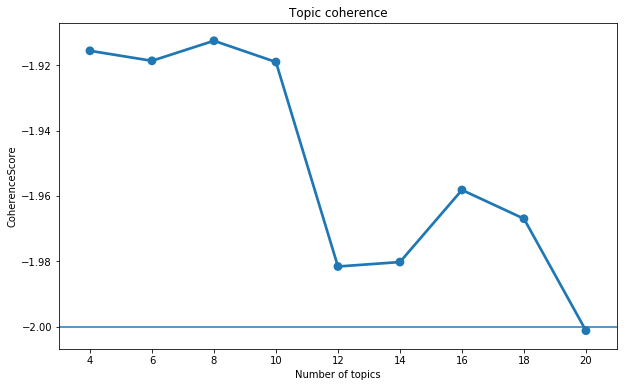

In [27]:
coherenceList_umass_final = coherenceList_umass_4_to_20
num_topics_list_final = np.arange(4, 21, 2)

plotData = pd.DataFrame({'Number of topics':num_topics_list_final,
                         'CoherenceScore':coherenceList_umass_final})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-2)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

In [46]:
%%time

# Set training parameters.
num_topics_list = np.arange(22, 31, 2)

chunksize = 5000    # number of docs processed at a time
passes = 2
iterations = 400
eval_every = None    # change to 1 if you want to check for convergence
eta = 0.01

coherenceList_umass = []

for num_topics in tqdm(num_topics_list):
    # training the model
    lda = LdaMulticore(bow_corpus, num_topics=num_topics, id2word=vocab_dictionary, chunksize=chunksize, 
                       passes=passes, eta=eta, eval_every=eval_every, iterations=iterations, random_state=42)
    print('Trained LDA for {} topics...'.format(num_topics))
    # performance metric
    cm = CoherenceModel(model=lda, corpus=bow_corpus, dictionary=vocab_dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    print('Calculated coherence score...: ', cm.get_coherence())
    # visualization
    vis = pyLDAvis.gensim.prepare(lda, bow_corpus, vocab_dictionary)
    plot_fname = 'pyLDAvis_{}.html'.format(num_topics)
    pyLDAvis.save_html(vis, plot_fname)
    print('Saved html file: ', plot_fname)

  0%|          | 0/5 [00:00<?, ?it/s]

Trained LDA for 22 topics...
Calculated coherence score...:  -1.99395785168


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 20%|██        | 1/5 [02:51<11:25, 171.34s/it]

Saved html file:  pyLDAvis_22.html
Trained LDA for 24 topics...
Calculated coherence score...:  -1.96784619686


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 40%|████      | 2/5 [05:44<08:36, 172.29s/it]

Saved html file:  pyLDAvis_24.html
Trained LDA for 26 topics...
Calculated coherence score...:  -1.97750390467


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 60%|██████    | 3/5 [08:36<05:44, 172.12s/it]

Saved html file:  pyLDAvis_26.html
Trained LDA for 28 topics...
Calculated coherence score...:  -1.94899748173


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
 80%|████████  | 4/5 [11:29<02:52, 172.26s/it]

Saved html file:  pyLDAvis_28.html
Trained LDA for 30 topics...
Calculated coherence score...:  -1.97290612729


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
100%|██████████| 5/5 [14:18<00:00, 171.71s/it]

Saved html file:  pyLDAvis_30.html
CPU times: user 14min 2s, sys: 27.1 s, total: 14min 29s
Wall time: 14min 18s


In [47]:
coherenceList_umass_22_to_30 = coherenceList_umass
coherenceList_umass_22_to_30

[-1.9939578516779293,
 -1.9678461968550742,
 -1.9775039046709368,
 -1.9489974817337186,
 -1.9729061272902821]

In [50]:
np.append(np.arange(4, 21, 2), np.arange(22, 31, 2))

array([ 4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])

In [26]:
# topic coherence plot
import matplotlib.pyplot as plt
import seaborn as sns

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/seaborn/categorical.py:342: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  elif is_categorical(y):


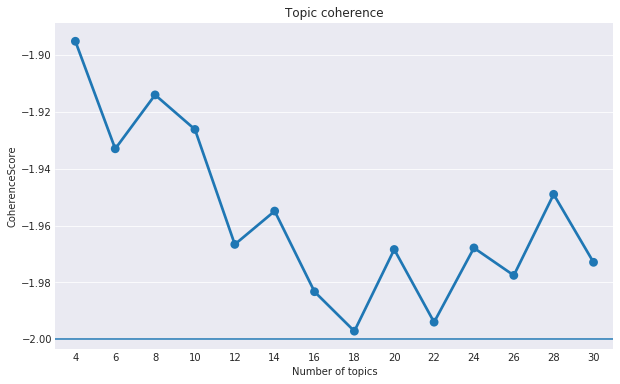

In [51]:
coherenceList_umass_final = coherenceList_umass_4_to_20 + coherenceList_umass_22_to_30
num_topics_list_final = np.append(np.arange(4, 21, 2), np.arange(22, 31, 2))

plotData = pd.DataFrame({'Number of topics':num_topics_list_final,
                         'CoherenceScore':coherenceList_umass_final})
f,ax = plt.subplots(figsize=(10,6))
sns.set_style("darkgrid")
sns.pointplot(x='Number of topics',y= 'CoherenceScore',data=plotData)
plt.axhline(y=-2)
plt.title('Topic coherence')
plt.savefig('Topic coherence plot.png')

In [29]:
%%time

# Set training parameters.
num_topics_list = [3]

chunksize = 5000    # number of docs processed at a time
passes = 5
iterations = 400
eval_every = None    # change to 1 if you want to check for convergence
eta = 0.001

coherenceList_umass = []

for num_topics in tqdm(num_topics_list):
    # training the model
    lda = LdaMulticore(bow_corpus, num_topics=num_topics, id2word=vocab_dictionary, chunksize=chunksize, 
                       passes=passes, eta=eta, eval_every=eval_every, iterations=iterations, random_state=42)
    print('Trained LDA for {} topics...'.format(num_topics))
    # performance metric
    cm = CoherenceModel(model=lda, corpus=bow_corpus, dictionary=vocab_dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    print('Calculated coherence score...: ', cm.get_coherence())
    # visualization
    vis = pyLDAvis.gensim.prepare(lda, bow_corpus, vocab_dictionary)
    plot_fname = 'pyLDAvis_{}.html'.format(num_topics)
    pyLDAvis.save_html(vis, plot_fname)
    print('Saved html file: ', plot_fname)

  0%|          | 0/1 [00:00<?, ?it/s]/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Trained LDA for 3 topics...
Calculated coherence score...:  -1.88409664898


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
100%|██████████| 1/1 [08:57<00:00, 537.58s/it]

Saved html file:  pyLDAvis_3.html
CPU times: user 9min 6s, sys: 28.1 s, total: 9min 34s
Wall time: 8min 57s


In [31]:
%%time

# Set training parameters.
num_topics_list = [3]

chunksize = 5000    # number of docs processed at a time
passes = 2
iterations = 400
eval_every = None    # change to 1 if you want to check for convergence
eta = 0.01

coherenceList_umass = []

for num_topics in tqdm(num_topics_list):
    # training the model
    lda = LdaModel(bow_corpus, num_topics=num_topics, id2word=vocab_dictionary, chunksize=chunksize, 
                       passes=passes, eta=eta, alpha='auto', eval_every=eval_every, iterations=iterations, random_state=42)
    print('Trained LDA for {} topics...'.format(num_topics))
    # performance metric
    cm = CoherenceModel(model=lda, corpus=bow_corpus, dictionary=vocab_dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    print('Calculated coherence score...: ', cm.get_coherence())
    # visualization
    vis = pyLDAvis.gensim.prepare(lda, bow_corpus, vocab_dictionary)
    plot_fname = 'pyLDAvis_{}.html'.format(num_topics)
    pyLDAvis.save_html(vis, plot_fname)
    print('Saved html file: ', plot_fname)

  0%|          | 0/1 [00:00<?, ?it/s]/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Trained LDA for 3 topics...
Calculated coherence score...:  -1.92659410355


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
100%|██████████| 1/1 [07:58<00:00, 478.14s/it]

Saved html file:  pyLDAvis_3.html
CPU times: user 7min 57s, sys: 460 ms, total: 7min 58s
Wall time: 7min 58s


In [33]:
%%time

# Set training parameters.
num_topics_list = [3]

chunksize = 5000    # number of docs processed at a time
passes = 2
iterations = 400
eval_every = None    # change to 1 if you want to check for convergence
eta = 'auto'

coherenceList_umass = []

for num_topics in tqdm(num_topics_list):
    # training the model
    lda = LdaModel(bow_corpus, num_topics=num_topics, id2word=vocab_dictionary, chunksize=chunksize, 
                       passes=passes, eta=eta, alpha='auto', eval_every=eval_every, iterations=iterations, random_state=42)
    print('Trained LDA for {} topics...'.format(num_topics))
    # performance metric
    cm = CoherenceModel(model=lda, corpus=bow_corpus, dictionary=vocab_dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    print('Calculated coherence score...: ', cm.get_coherence())
    # visualization
    vis = pyLDAvis.gensim.prepare(lda, bow_corpus, vocab_dictionary)
    plot_fname = 'pyLDAvis_{}.html'.format(num_topics)
    pyLDAvis.save_html(vis, plot_fname)
    print('Saved html file: ', plot_fname)

  0%|          | 0/1 [00:00<?, ?it/s]INFO : using autotuned alpha, starting with [0.33333334, 0.33333334, 0.33333334]
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 3 topics, 2 passes over the supplied corpus of 217530 documents, updating model once every 5000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #5000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 4688/5000 documents converged within 400 iterations
INFO : optimized alpha [0.10189506, 0.12627771, 0.19753681]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.102): 0.027*"pedometer" + 0.023*"day" + 0.022*"step" + 0.019*"use" + 0.016*"great" + 0.015*"like" + 0.014*"good" + 0.014*"work" + 0.011*"walk" + 0.011*"product"
INFO : topic #1 (0.126): 0.031*"pedometer" + 0.023*"great" + 0.022*"use" + 0

INFO : topic #1 (0.133): 0.032*"product" + 0.030*"good" + 0.028*"great" + 0.022*"taste" + 0.018*"use" + 0.014*"like" + 0.012*"price" + 0.009*"love" + 0.009*"work" + 0.009*"easy"
INFO : topic #2 (0.169): 0.042*"product" + 0.028*"use" + 0.023*"good" + 0.020*"great" + 0.016*"work" + 0.011*"year" + 0.011*"skin" + 0.011*"love" + 0.010*"oil" + 0.009*"help"
INFO : topic diff=0.876601, rho=0.333333
INFO : PROGRESS: pass 0, at document #50000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.16377582, 0.1369579, 0.16623648]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.164): 0.017*"day" + 0.016*"help" + 0.016*"work" + 0.015*"product" + 0.014*"good" + 0.011*"use" + 0.011*"feel" + 0.010*"try" + 0.010*"year" + 0.009*"supplement"
INFO : topic #1 (0.137): 0.033*"product" + 0.032*"good" + 0.028*"great" + 0.022*"taste" + 0.017*"us

INFO : topic #2 (0.163): 0.046*"product" + 0.030*"use" + 0.022*"great" + 0.020*"good" + 0.018*"work" + 0.012*"skin" + 0.011*"year" + 0.010*"love" + 0.010*"help" + 0.010*"hair"
INFO : topic diff=0.405967, rho=0.235702
INFO : PROGRESS: pass 0, at document #95000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.21594854, 0.16939266, 0.1610783]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.216): 0.018*"day" + 0.017*"help" + 0.016*"work" + 0.015*"product" + 0.013*"good" + 0.012*"feel" + 0.010*"use" + 0.010*"supplement" + 0.010*"try" + 0.009*"year"
INFO : topic #1 (0.169): 0.038*"good" + 0.033*"product" + 0.028*"great" + 0.019*"taste" + 0.017*"use" + 0.015*"price" + 0.014*"like" + 0.011*"vitamin" + 0.009*"brand" + 0.009*"find"
INFO : topic #2 (0.161): 0.046*"product" + 0.030*"use" + 0.023*"great" + 0.020*"good" + 0.018*

INFO : topic #2 (0.163): 0.045*"product" + 0.031*"use" + 0.023*"great" + 0.019*"good" + 0.018*"work" + 0.013*"skin" + 0.012*"love" + 0.011*"year" + 0.010*"oil" + 0.010*"help"
INFO : topic diff=0.256538, rho=0.192450
INFO : PROGRESS: pass 0, at document #140000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.22345941, 0.22233807, 0.16474791]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.223): 0.018*"day" + 0.017*"work" + 0.016*"help" + 0.016*"product" + 0.013*"good" + 0.012*"feel" + 0.010*"try" + 0.010*"use" + 0.009*"year" + 0.009*"recommend"
INFO : topic #1 (0.222): 0.037*"good" + 0.032*"product" + 0.028*"great" + 0.023*"taste" + 0.015*"price" + 0.014*"like" + 0.014*"use" + 0.011*"vitamin" + 0.011*"love" + 0.010*"easy"
INFO : topic #2 (0.165): 0.046*"product" + 0.031*"use" + 0.023*"great" + 0.019*"good" + 0.018*"

INFO : topic diff=0.229910, rho=0.166667
INFO : PROGRESS: pass 0, at document #185000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 4999/5000 documents converged within 400 iterations
INFO : optimized alpha [0.24644768, 0.24781859, 0.17510521]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.246): 0.018*"work" + 0.018*"product" + 0.017*"day" + 0.017*"help" + 0.013*"good" + 0.012*"feel" + 0.011*"use" + 0.010*"try" + 0.009*"supplement" + 0.009*"recommend"
INFO : topic #1 (0.248): 0.036*"good" + 0.033*"product" + 0.029*"great" + 0.021*"taste" + 0.015*"like" + 0.014*"price" + 0.013*"use" + 0.012*"vitamin" + 0.012*"easy" + 0.011*"love"
INFO : topic #2 (0.175): 0.048*"product" + 0.030*"use" + 0.023*"great" + 0.018*"good" + 0.018*"work" + 0.012*"love" + 0.012*"skin" + 0.012*"hair" + 0.010*"oil" + 0.010*"feel"
INFO : topic diff=0.237234, rho=0.164399
INFO : PROGRESS: pass 0, at document #190000/217

INFO : topic diff=0.257039, rho=0.148240
INFO : PROGRESS: pass 1, at document #10000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.27774319, 0.26448378, 0.19843139]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.278): 0.019*"day" + 0.018*"work" + 0.017*"product" + 0.015*"help" + 0.013*"good" + 0.013*"feel" + 0.011*"try" + 0.011*"use" + 0.010*"supplement" + 0.009*"recommend"
INFO : topic #1 (0.264): 0.032*"product" + 0.032*"good" + 0.028*"great" + 0.017*"taste" + 0.016*"easy" + 0.015*"like" + 0.013*"use" + 0.012*"price" + 0.010*"love" + 0.010*"supplement"
INFO : topic #2 (0.198): 0.047*"product" + 0.031*"use" + 0.024*"great" + 0.020*"skin" + 0.017*"work" + 0.017*"good" + 0.014*"love" + 0.012*"feel" + 0.010*"recommend" + 0.010*"look"
INFO : topic diff=0.165602, rho=0.148240
INFO : PROGRESS: pass 1, at document #15

INFO : topic diff=0.141522, rho=0.148240
INFO : PROGRESS: pass 1, at document #55000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.31081998, 0.26782376, 0.19167262]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.311): 0.019*"work" + 0.018*"help" + 0.018*"day" + 0.018*"product" + 0.013*"good" + 0.012*"use" + 0.011*"feel" + 0.010*"try" + 0.010*"year" + 0.009*"recommend"
INFO : topic #1 (0.268): 0.035*"good" + 0.033*"product" + 0.028*"great" + 0.020*"taste" + 0.015*"like" + 0.014*"use" + 0.014*"price" + 0.011*"easy" + 0.010*"love" + 0.009*"vitamin"
INFO : topic #2 (0.192): 0.044*"product" + 0.033*"use" + 0.023*"great" + 0.019*"work" + 0.017*"good" + 0.016*"skin" + 0.014*"love" + 0.010*"year" + 0.010*"feel" + 0.009*"hair"
INFO : topic diff=0.139595, rho=0.148240
INFO : PROGRESS: pass 1, at document #60000/217530
DEB

INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #100000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 4998/5000 documents converged within 400 iterations
INFO : optimized alpha [0.34586594, 0.28588685, 0.18395825]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.346): 0.018*"work" + 0.018*"product" + 0.018*"help" + 0.017*"day" + 0.013*"good" + 0.012*"feel" + 0.012*"use" + 0.010*"try" + 0.010*"year" + 0.009*"recommend"
INFO : topic #1 (0.286): 0.038*"good" + 0.033*"product" + 0.029*"great" + 0.019*"taste" + 0.016*"use" + 0.015*"price" + 0.014*"like" + 0.011*"vitamin" + 0.010*"love" + 0.010*"brand"
INFO : topic #2 (0.184): 0.043*"product" + 0.034*"use" + 0.023*"great" + 0.018*"work" + 0.016*"good" + 0.015*"skin" + 0.013*"love" + 0.011*"hair" + 0.010*"year" + 0.009*"feel"
INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #105000/217530
DEBUG : pe

DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.35028732, 0.34638438, 0.18253745]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.350): 0.019*"product" + 0.019*"work" + 0.018*"help" + 0.018*"day" + 0.013*"good" + 0.012*"feel" + 0.011*"use" + 0.011*"try" + 0.010*"recommend" + 0.010*"year"
INFO : topic #1 (0.346): 0.037*"good" + 0.032*"product" + 0.028*"great" + 0.022*"taste" + 0.015*"price" + 0.014*"like" + 0.013*"use" + 0.012*"vitamin" + 0.011*"easy" + 0.011*"love"
INFO : topic #2 (0.183): 0.042*"product" + 0.033*"use" + 0.022*"great" + 0.018*"work" + 0.016*"good" + 0.015*"skin" + 0.014*"love" + 0.011*"year" + 0.010*"feel" + 0.010*"hair"
INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #150000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged wit

INFO : optimized alpha [0.38964218, 0.38219705, 0.18994355]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.390): 0.021*"product" + 0.020*"work" + 0.017*"help" + 0.017*"day" + 0.014*"good" + 0.013*"feel" + 0.012*"use" + 0.011*"try" + 0.010*"recommend" + 0.009*"supplement"
INFO : topic #1 (0.382): 0.037*"good" + 0.035*"product" + 0.030*"great" + 0.021*"taste" + 0.015*"like" + 0.014*"price" + 0.013*"use" + 0.012*"vitamin" + 0.011*"easy" + 0.011*"love"
INFO : topic #2 (0.190): 0.042*"product" + 0.032*"use" + 0.022*"great" + 0.018*"work" + 0.015*"hair" + 0.015*"skin" + 0.015*"good" + 0.014*"love" + 0.010*"feel" + 0.009*"year"
INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #195000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.39959955, 0.387252, 0.19075982]
DEBUG : updating topics
INFO : merg

Trained LDA for 3 topics...


INFO : CorpusAccumulator accumulated stats from 15000 documents
INFO : CorpusAccumulator accumulated stats from 16000 documents
INFO : CorpusAccumulator accumulated stats from 17000 documents
INFO : CorpusAccumulator accumulated stats from 18000 documents
INFO : CorpusAccumulator accumulated stats from 19000 documents
INFO : CorpusAccumulator accumulated stats from 20000 documents
INFO : CorpusAccumulator accumulated stats from 21000 documents
INFO : CorpusAccumulator accumulated stats from 22000 documents
INFO : CorpusAccumulator accumulated stats from 23000 documents
INFO : CorpusAccumulator accumulated stats from 24000 documents
INFO : CorpusAccumulator accumulated stats from 25000 documents
INFO : CorpusAccumulator accumulated stats from 26000 documents
INFO : CorpusAccumulator accumulated stats from 27000 documents
INFO : CorpusAccumulator accumulated stats from 28000 documents
INFO : CorpusAccumulator accumulated stats from 29000 documents
INFO : CorpusAccumulator accumulated sta

INFO : CorpusAccumulator accumulated stats from 143000 documents
INFO : CorpusAccumulator accumulated stats from 144000 documents
INFO : CorpusAccumulator accumulated stats from 145000 documents
INFO : CorpusAccumulator accumulated stats from 146000 documents
INFO : CorpusAccumulator accumulated stats from 147000 documents
INFO : CorpusAccumulator accumulated stats from 148000 documents
INFO : CorpusAccumulator accumulated stats from 149000 documents
INFO : CorpusAccumulator accumulated stats from 150000 documents
INFO : CorpusAccumulator accumulated stats from 151000 documents
INFO : CorpusAccumulator accumulated stats from 152000 documents
INFO : CorpusAccumulator accumulated stats from 153000 documents
INFO : CorpusAccumulator accumulated stats from 154000 documents
INFO : CorpusAccumulator accumulated stats from 155000 documents
INFO : CorpusAccumulator accumulated stats from 156000 documents
INFO : CorpusAccumulator accumulated stats from 157000 documents
INFO : CorpusAccumulator 

Calculated coherence score...:  -1.91109565269


DEBUG : performing inference on a chunk of 217530 documents
DEBUG : 217513/217530 documents converged within 400 iterations
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
100%|██████████| 1/1 [08:17<00:00, 497.73s/it]

Saved html file:  pyLDAvis_3.html
CPU times: user 8min 17s, sys: 1.45 s, total: 8min 19s
Wall time: 8min 17s


In [34]:
%%time

# Set training parameters.
num_topics_list = [4]

chunksize = 5000    # number of docs processed at a time
passes = 2
iterations = 400
eval_every = None    # change to 1 if you want to check for convergence
eta = 'auto'

coherenceList_umass = []

for num_topics in tqdm(num_topics_list):
    # training the model
    lda = LdaModel(bow_corpus, num_topics=num_topics, id2word=vocab_dictionary, chunksize=chunksize, 
                       passes=passes, eta=eta, alpha='auto', eval_every=eval_every, iterations=iterations, random_state=42)
    print('Trained LDA for {} topics...'.format(num_topics))
    # performance metric
    cm = CoherenceModel(model=lda, corpus=bow_corpus, dictionary=vocab_dictionary, coherence='u_mass')
    coherenceList_umass.append(cm.get_coherence())
    print('Calculated coherence score...: ', cm.get_coherence())
    # visualization
    vis = pyLDAvis.gensim.prepare(lda, bow_corpus, vocab_dictionary)
    plot_fname = 'pyLDAvis_{}.html'.format(num_topics)
    pyLDAvis.save_html(vis, plot_fname)
    print('Saved html file: ', plot_fname)

  0%|          | 0/1 [00:00<?, ?it/s]INFO : using autotuned alpha, starting with [0.25, 0.25, 0.25, 0.25]
INFO : using serial LDA version on this node
INFO : running online (multi-pass) LDA training, 4 topics, 2 passes over the supplied corpus of 217530 documents, updating model once every 5000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
INFO : PROGRESS: pass 0, at document #5000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 4802/5000 documents converged within 400 iterations
INFO : optimized alpha [0.071542129, 0.077272058, 0.119746, 0.16022271]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.072): 0.024*"pedometer" + 0.020*"step" + 0.018*"day" + 0.016*"use" + 0.015*"like" + 0.015*"great" + 0.015*"work" + 0.014*"good" + 0.010*"product" + 0.010*"walk"
INFO : topic #1 (0.077): 0.030*"pedometer" + 0.023*"great" + 0.019*"work" + 

INFO : PROGRESS: pass 0, at document #40000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 4999/5000 documents converged within 400 iterations
INFO : optimized alpha [0.13793305, 0.12544386, 0.14942284, 0.078478105]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.138): 0.018*"help" + 0.016*"day" + 0.015*"work" + 0.014*"good" + 0.014*"product" + 0.011*"feel" + 0.010*"use" + 0.010*"year" + 0.009*"try" + 0.009*"supplement"
INFO : topic #1 (0.125): 0.032*"product" + 0.031*"good" + 0.027*"great" + 0.018*"taste" + 0.016*"use" + 0.014*"price" + 0.012*"like" + 0.010*"work" + 0.009*"find" + 0.009*"brand"
INFO : topic #2 (0.149): 0.045*"product" + 0.028*"use" + 0.025*"good" + 0.022*"great" + 0.015*"work" + 0.013*"skin" + 0.012*"love" + 0.011*"year" + 0.010*"feel" + 0.010*"recommend"
INFO : topic #3 (0.078): 0.022*"use" + 0.020*"day" + 0.018*"product" + 0.015*"work" + 0.012*"great" + 0.012*"good" + 0.

INFO : topic #2 (0.166): 0.050*"product" + 0.033*"use" + 0.024*"great" + 0.023*"good" + 0.017*"work" + 0.013*"love" + 0.012*"skin" + 0.012*"year" + 0.011*"recommend" + 0.010*"feel"
INFO : topic #3 (0.086): 0.020*"day" + 0.019*"use" + 0.016*"work" + 0.016*"product" + 0.011*"pain" + 0.009*"week" + 0.009*"knee" + 0.009*"time" + 0.009*"good" + 0.008*"great"
INFO : topic diff=0.516210, rho=0.258199
INFO : PROGRESS: pass 0, at document #80000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.21004938, 0.17551881, 0.17007166, 0.088186264]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.210): 0.018*"help" + 0.017*"work" + 0.017*"day" + 0.015*"product" + 0.013*"good" + 0.011*"feel" + 0.011*"try" + 0.010*"year" + 0.010*"use" + 0.009*"recommend"
INFO : topic #1 (0.176): 0.039*"good" + 0.036*"product" + 0.028*"great" + 0.021*"ta

DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.25213236, 0.24352716, 0.18381326, 0.095906407]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.252): 0.019*"help" + 0.017*"day" + 0.017*"work" + 0.014*"product" + 0.012*"good" + 0.011*"feel" + 0.011*"try" + 0.010*"supplement" + 0.010*"year" + 0.010*"use"
INFO : topic #1 (0.244): 0.039*"good" + 0.035*"product" + 0.029*"great" + 0.021*"taste" + 0.016*"price" + 0.015*"use" + 0.014*"like" + 0.012*"vitamin" + 0.011*"easy" + 0.011*"find"
INFO : topic #2 (0.184): 0.048*"product" + 0.033*"use" + 0.025*"great" + 0.021*"good" + 0.017*"work" + 0.013*"love" + 0.013*"oil" + 0.012*"skin" + 0.012*"year" + 0.011*"recommend"
INFO : topic #3 (0.096): 0.020*"day" + 0.017*"pain" + 0.016*"use" + 0.016*"work" + 0.014*"product" + 0.010*"week" + 0.009*"time" + 0.008*"lose" + 0.008*"knee" + 0.007*"good"
INFO : topic diff=0.283046, rho=0.208514
INFO : PROGR

INFO : topic #2 (0.203): 0.049*"product" + 0.034*"use" + 0.025*"great" + 0.021*"good" + 0.016*"work" + 0.015*"love" + 0.014*"oil" + 0.013*"skin" + 0.012*"recommend" + 0.012*"year"
INFO : topic #3 (0.104): 0.019*"day" + 0.018*"work" + 0.017*"pain" + 0.015*"use" + 0.014*"product" + 0.012*"week" + 0.009*"lose" + 0.009*"time" + 0.009*"knee" + 0.008*"start"
INFO : topic diff=0.231554, rho=0.182574
INFO : PROGRESS: pass 0, at document #155000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 4999/5000 documents converged within 400 iterations
INFO : optimized alpha [0.28211904, 0.32298255, 0.20485008, 0.10508583]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.282): 0.018*"help" + 0.018*"work" + 0.017*"day" + 0.016*"product" + 0.012*"good" + 0.012*"feel" + 0.011*"try" + 0.010*"recommend" + 0.010*"year" + 0.010*"use"
INFO : topic #1 (0.323): 0.039*"good" + 0.034*"product" + 0.030*"great" + 0.023*"tas

DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.31410238, 0.37545675, 0.22444569, 0.11624651]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.314): 0.018*"help" + 0.018*"work" + 0.017*"product" + 0.016*"day" + 0.012*"good" + 0.012*"feel" + 0.011*"try" + 0.011*"supplement" + 0.010*"use" + 0.010*"recommend"
INFO : topic #1 (0.375): 0.039*"good" + 0.037*"product" + 0.032*"great" + 0.022*"taste" + 0.016*"like" + 0.015*"price" + 0.012*"use" + 0.012*"easy" + 0.012*"vitamin" + 0.011*"love"
INFO : topic #2 (0.224): 0.051*"product" + 0.033*"use" + 0.025*"great" + 0.019*"good" + 0.016*"work" + 0.015*"love" + 0.015*"oil" + 0.015*"hair" + 0.014*"skin" + 0.012*"feel"
INFO : topic #3 (0.116): 0.021*"work" + 0.019*"day" + 0.017*"pain" + 0.016*"product" + 0.015*"use" + 0.013*"week" + 0.010*"lose" + 0.009*"feel" + 0.009*"time" + 0.009*"try"
INFO : topic diff=0.199499, rho=0.162221
INFO : PROGRES

INFO : topic #1 (0.399): 0.038*"product" + 0.036*"good" + 0.033*"great" + 0.017*"taste" + 0.016*"easy" + 0.016*"like" + 0.013*"price" + 0.012*"supplement" + 0.012*"use" + 0.011*"love"
INFO : topic #2 (0.235): 0.053*"product" + 0.032*"use" + 0.025*"skin" + 0.024*"great" + 0.018*"good" + 0.015*"love" + 0.015*"work" + 0.015*"feel" + 0.012*"recommend" + 0.012*"look"
INFO : topic #3 (0.144): 0.024*"pedometer" + 0.022*"day" + 0.020*"work" + 0.016*"use" + 0.014*"product" + 0.013*"week" + 0.013*"lose" + 0.012*"step" + 0.011*"pain" + 0.009*"try"
INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #10000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.30801642, 0.40144274, 0.23237318, 0.14530329]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.308): 0.018*"help" + 0.017*"work" + 0.017*"product" + 0.016*"

INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #45000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.37096035, 0.43913531, 0.24557011, 0.14199896]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.371): 0.020*"help" + 0.018*"work" + 0.016*"product" + 0.016*"day" + 0.013*"good" + 0.012*"feel" + 0.011*"year" + 0.011*"try" + 0.011*"use" + 0.009*"supplement"
INFO : topic #1 (0.439): 0.039*"good" + 0.038*"product" + 0.033*"great" + 0.020*"taste" + 0.015*"price" + 0.015*"like" + 0.014*"use" + 0.012*"easy" + 0.011*"love" + 0.011*"buy"
INFO : topic #2 (0.246): 0.046*"product" + 0.036*"use" + 0.023*"great" + 0.020*"skin" + 0.017*"good" + 0.016*"work" + 0.015*"love" + 0.013*"oil" + 0.013*"feel" + 0.012*"hair"
INFO : topic #3 (0.142): 0.023*"day" + 0.020*"work" + 0.017*"use" + 0.016*"pain" + 0.014*"pe

INFO : topic #2 (0.245): 0.046*"product" + 0.038*"use" + 0.023*"great" + 0.019*"skin" + 0.017*"work" + 0.016*"good" + 0.015*"love" + 0.012*"hair" + 0.012*"feel" + 0.011*"year"
INFO : topic #3 (0.148): 0.023*"day" + 0.021*"work" + 0.020*"pain" + 0.016*"use" + 0.012*"week" + 0.012*"product" + 0.009*"lose" + 0.009*"joint" + 0.009*"feel" + 0.009*"time"
INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #85000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.46957549, 0.49226803, 0.2451973, 0.1487578]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.470): 0.020*"help" + 0.019*"work" + 0.017*"product" + 0.016*"day" + 0.012*"good" + 0.012*"year" + 0.011*"feel" + 0.011*"use" + 0.011*"try" + 0.010*"recommend"
INFO : topic #1 (0.492): 0.042*"good" + 0.040*"product" + 0.033*"great" + 0.019*"taste" + 0.016*

DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.531): 0.020*"help" + 0.019*"work" + 0.017*"day" + 0.016*"product" + 0.012*"good" + 0.012*"year" + 0.011*"feel" + 0.011*"try" + 0.011*"use" + 0.010*"recommend"
INFO : topic #1 (0.601): 0.042*"good" + 0.039*"product" + 0.033*"great" + 0.020*"taste" + 0.016*"price" + 0.015*"like" + 0.015*"use" + 0.013*"vitamin" + 0.011*"buy" + 0.011*"love"
INFO : topic #2 (0.247): 0.041*"product" + 0.037*"use" + 0.020*"great" + 0.017*"skin" + 0.016*"work" + 0.014*"love" + 0.014*"good" + 0.014*"hair" + 0.012*"oil" + 0.011*"year"
INFO : topic #3 (0.153): 0.023*"day" + 0.021*"pain" + 0.020*"work" + 0.014*"use" + 0.013*"week" + 0.011*"product" + 0.011*"feel" + 0.010*"lose" + 0.009*"start" + 0.009*"time"
INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #125000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 4999/5000 documents converged within 4

INFO : topic #3 (0.159): 0.022*"day" + 0.021*"work" + 0.021*"pain" + 0.014*"use" + 0.013*"week" + 0.013*"feel" + 0.012*"product" + 0.010*"energy" + 0.010*"start" + 0.010*"lose"
INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #160000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.57913595, 0.71705443, 0.26244733, 0.15843648]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.579): 0.020*"help" + 0.020*"work" + 0.018*"product" + 0.017*"day" + 0.012*"feel" + 0.012*"year" + 0.011*"good" + 0.011*"recommend" + 0.011*"use" + 0.011*"try"
INFO : topic #1 (0.717): 0.042*"good" + 0.041*"product" + 0.034*"great" + 0.020*"taste" + 0.015*"price" + 0.015*"like" + 0.014*"use" + 0.013*"vitamin" + 0.012*"love" + 0.012*"buy"
INFO : topic #2 (0.262): 0.037*"product" + 0.036*"use" + 0.024*"hair" + 0.018*"skin" + 

INFO : topic #1 (0.803): 0.044*"product" + 0.042*"good" + 0.036*"great" + 0.020*"taste" + 0.016*"like" + 0.014*"price" + 0.014*"use" + 0.013*"love" + 0.012*"vitamin" + 0.011*"buy"
INFO : topic #2 (0.268): 0.036*"product" + 0.034*"use" + 0.020*"skin" + 0.019*"hair" + 0.016*"great" + 0.015*"oil" + 0.014*"work" + 0.013*"love" + 0.011*"good" + 0.010*"feel"
INFO : topic #3 (0.176): 0.023*"work" + 0.022*"day" + 0.019*"pain" + 0.016*"feel" + 0.015*"week" + 0.015*"energy" + 0.013*"use" + 0.013*"product" + 0.010*"lose" + 0.010*"try"
INFO : topic diff=inf, rho=0.148240
INFO : PROGRESS: pass 1, at document #200000/217530
DEBUG : performing inference on a chunk of 5000 documents
DEBUG : 5000/5000 documents converged within 400 iterations
INFO : optimized alpha [0.65030593, 0.82227945, 0.26846364, 0.17844512]
DEBUG : updating topics
INFO : merging changes from 5000 documents into a model of 217530 documents
INFO : topic #0 (0.650): 0.020*"work" + 0.020*"help" + 0.019*"product" + 0.016*"day" + 0.013

Trained LDA for 4 topics...


INFO : CorpusAccumulator accumulated stats from 15000 documents
INFO : CorpusAccumulator accumulated stats from 16000 documents
INFO : CorpusAccumulator accumulated stats from 17000 documents
INFO : CorpusAccumulator accumulated stats from 18000 documents
INFO : CorpusAccumulator accumulated stats from 19000 documents
INFO : CorpusAccumulator accumulated stats from 20000 documents
INFO : CorpusAccumulator accumulated stats from 21000 documents
INFO : CorpusAccumulator accumulated stats from 22000 documents
INFO : CorpusAccumulator accumulated stats from 23000 documents
INFO : CorpusAccumulator accumulated stats from 24000 documents
INFO : CorpusAccumulator accumulated stats from 25000 documents
INFO : CorpusAccumulator accumulated stats from 26000 documents
INFO : CorpusAccumulator accumulated stats from 27000 documents
INFO : CorpusAccumulator accumulated stats from 28000 documents
INFO : CorpusAccumulator accumulated stats from 29000 documents
INFO : CorpusAccumulator accumulated sta

INFO : CorpusAccumulator accumulated stats from 143000 documents
INFO : CorpusAccumulator accumulated stats from 144000 documents
INFO : CorpusAccumulator accumulated stats from 145000 documents
INFO : CorpusAccumulator accumulated stats from 146000 documents
INFO : CorpusAccumulator accumulated stats from 147000 documents
INFO : CorpusAccumulator accumulated stats from 148000 documents
INFO : CorpusAccumulator accumulated stats from 149000 documents
INFO : CorpusAccumulator accumulated stats from 150000 documents
INFO : CorpusAccumulator accumulated stats from 151000 documents
INFO : CorpusAccumulator accumulated stats from 152000 documents
INFO : CorpusAccumulator accumulated stats from 153000 documents
INFO : CorpusAccumulator accumulated stats from 154000 documents
INFO : CorpusAccumulator accumulated stats from 155000 documents
INFO : CorpusAccumulator accumulated stats from 156000 documents
INFO : CorpusAccumulator accumulated stats from 157000 documents
INFO : CorpusAccumulator 

Calculated coherence score...:  -2.06630931667


DEBUG : performing inference on a chunk of 217530 documents
DEBUG : 217529/217530 documents converged within 400 iterations
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]
100%|██████████| 1/1 [07:28<00:00, 448.26s/it]

Saved html file:  pyLDAvis_4.html
CPU times: user 7min 28s, sys: 1.67 s, total: 7min 29s
Wall time: 7min 28s


In [36]:
vis.topic_info

,Category,Freq,Term,Total,loglift,logprob
term,,,,,,
223,Default,26627.000000,skin,26627.000000,30.0000,30.0000
215,Default,82429.000000,use,82429.000000,29.0000,29.0000
419,Default,33312.000000,taste,33312.000000,28.0000,28.0000
189,Default,69615.000000,work,69615.000000,27.0000,27.0000
62,Default,57529.000000,feel,57529.000000,26.0000,26.0000
32,Default,179709.000000,product,179709.000000,25.0000,25.0000
17,Default,98615.000000,great,98615.000000,24.0000,24.0000
159,Default,29696.000000,week,29696.000000,23.0000,23.0000
8,Default,57246.000000,day,57246.000000,22.0000,22.0000


# Guided LDA

In [37]:
print(vocab_dictionary)

Dictionary(13850 unique tokens: ['accord', 'acid', 'anticipate', 'bioavailability', 'break']...)


In [40]:
len(tokenized_reviews)

217530

In [42]:
import guidedlda
X = guidedlda.datasets.load_data(guidedlda.datasets.NYT)
vocab = guidedlda.datasets.load_vocab(guidedlda.datasets.NYT)
word2id = dict((v, idx) for idx, v in enumerate(vocab))

In [53]:
X

array([[0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 1, ..., 0, 0, 0]], dtype=int32)

In [96]:
X.shape

(8447, 3012)

In [97]:
len(vocab)

3012

In [60]:
len(vocab_dictionary.token2id)

13850

In [58]:
from sklearn.feature_extraction.text import CountVectorizer 

In [61]:
vectorizer = CountVectorizer(tokenized_reviews, vocabulary=vocab_dictionary.token2id)

In [84]:
tokenized_reviews_for_CV = [' '.join(sent) for sent in tokenized_reviews]

In [86]:
tokenized_reviews_for_CV[0]

'bioavailability key start parent die cancer suppose enhance immune_system story resveratrol minutes incredibly inspiring research internet indicate resveratrol lozenge form preferable stomach acid break ez melt formula recommend review ok dissolve mouth quickly lozenge formula dissolve slowly preferable accord research great side_effect cold sore_throat product soon start start come cold usual symptom anticipate sick day usual pattern day sick anticipate taking reason come product cold sore_throat great recommend know gift family product'

In [102]:
vocab_glda = list(vocab_dictionary.token2id.keys())

In [104]:
word2id_glda = dict((v, idx) for idx, v in enumerate(vocab_glda))

In [95]:
x1 = vectorizer.fit_transform(tokenized_reviews_for_CV)

In [136]:
efficacy = ['quality', 'work', 'help', 'result', 'notice', 'help', 'effect', 'effective', 'outcome', 'high_quality', ]
cost = ['price', 'cost', 'money', 'expensive', 'cheap', 'value', 'worth']
seller = ['seller', 'shipping', 'service', 'ship', 'customer', 'customer_service', 'timely', 'company', 'order', 'refund', 'return']

seed_topic_list = [efficacy, cost, seller]

In [137]:
model_glda = guidedlda.GuidedLDA(n_topics=3, n_iter=2000, random_state=42, refresh=20)

In [138]:
seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id_glda[word]] = t_id

In [139]:
seed_topics

{54: 2,
 99: 1,
 105: 0,
 127: 2,
 182: 0,
 189: 0,
 209: 2,
 283: 2,
 284: 2,
 297: 0,
 336: 2,
 453: 0,
 465: 1,
 481: 1,
 485: 1,
 487: 1,
 519: 2,
 558: 0,
 592: 1,
 767: 0,
 832: 0,
 1313: 1,
 1579: 2,
 1708: 2,
 1881: 0,
 3418: 2,
 6354: 2}

In [141]:
%%time
model_glda.fit(x1, seed_topics=seed_topics, seed_confidence=0.8)

INFO : n_documents: 217530
INFO : vocab_size: 13850
INFO : n_words: 5561527
INFO : n_topics: 3
INFO : n_iter: 2000
INFO : <0> log likelihood: -47812361
INFO : <20> log likelihood: -40464911
INFO : <40> log likelihood: -40060390
INFO : <60> log likelihood: -39947251
INFO : <80> log likelihood: -39894673
INFO : <100> log likelihood: -39854744
INFO : <120> log likelihood: -39820507
INFO : <140> log likelihood: -39801913
INFO : <160> log likelihood: -39790895
INFO : <180> log likelihood: -39775106
INFO : <200> log likelihood: -39766755
INFO : <220> log likelihood: -39758390
INFO : <240> log likelihood: -39753634
INFO : <260> log likelihood: -39752379
INFO : <280> log likelihood: -39750098
INFO : <300> log likelihood: -39747622
INFO : <320> log likelihood: -39746227
INFO : <340> log likelihood: -39748607
INFO : <360> log likelihood: -39748289
INFO : <380> log likelihood: -39750411
INFO : <400> log likelihood: -39750885
INFO : <420> log likelihood: -39749633
INFO : <440> log likelihood: -397

CPU times: user 9min 17s, sys: 152 ms, total: 9min 17s
Wall time: 9min 17s


In [142]:
bow_corpus

[[(0, 1),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 3),
  (7, 2),
  (8, 2),
  (9, 1),
  (10, 2),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 2),
  (16, 1),
  (17, 2),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 2),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 2),
  (32, 3),
  (33, 1),
  (34, 1),
  (35, 2),
  (36, 2),
  (37, 2),
  (38, 1),
  (39, 2),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 2),
  (44, 3),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 2)],
 [(26, 1),
  (27, 1),
  (32, 5),
  (37, 2),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 2),
  (63, 5),
  (64, 2),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 2),
  (87, 1

In [146]:
n_top_words = 40
topic_word = model_glda.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab_glda)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: product work good use day help great feel try year recommend start time like week month pain supplement find pill need notice problem stuff energy know sleep love buy result doctor think thing night body lot eat stomach tell life
Topic 1: product good great use supplement price recommend vitamin find easy like day buy work brand year pill fish_oil love need quality taste time order try capsule help oil excellent omega amazon mg swallow doctor purchase health feel bottle pedometer know
Topic 2: product good use great taste like love skin work hair try day buy feel drink water recommend stuff mix help flavor add time find oil look year easy vitamin bottle need way little price powder supplement tea start nail month
